In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

In [2]:
from scipy.io import loadmat, whosmat

# Inspect the contents of the .mat file
mat_contents_img = whosmat(r"C:\Users\ursti\Downloads\GAN\Datasets\Botswana\Botswana.mat")
mat_contents_gt = whosmat(r"C:\Users\ursti\Downloads\GAN\Datasets\Botswana\Botswana_gt.mat")

print(mat_contents_img)
print(mat_contents_gt)

[('Botswana', (1476, 256, 145), 'double')]
[('Botswana_gt', (1476, 256), 'double')]


In [3]:
img = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\Botswana\Botswana.mat")['Botswana']
gt = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\Botswana\Botswana_gt.mat")['Botswana_gt']

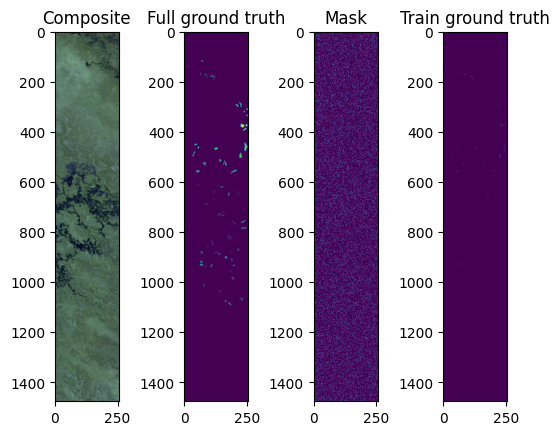

In [4]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

In [5]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim + c_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.apply(weight_init)

    def forward(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        return self.generator(inputs)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, 1)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.discriminator(x)
    
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.BatchNorm1d(h_dim),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, c_dim)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.classifier(x)


In [7]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

In [8]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]C:\Users\ursti\AppData\Local\Temp\ipykernel_19096\1864507184.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.log_softmax(C(X))


Iter-0; D_loss: 265.9960021972656; G_loss: -0.8370416760444641; C_loss: 4.414913654327393


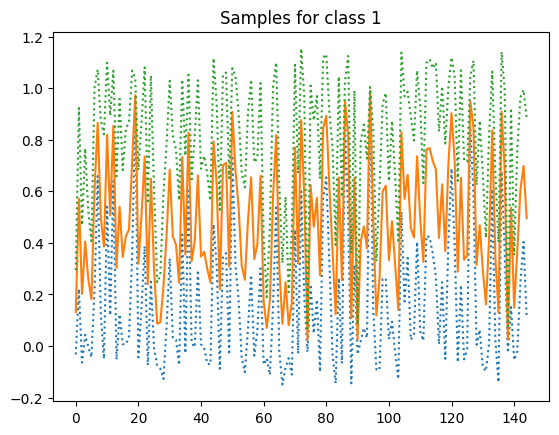

  1%|▋                                                                         | 1000/100000 [01:10<1:51:25, 14.81it/s]

Iter-1000; D_loss: -0.2899795174598694; G_loss: 0.163504496216774; C_loss: 1.2451454401016235


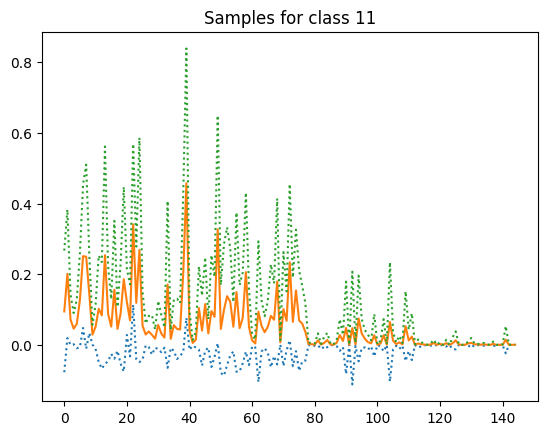

  2%|█▍                                                                        | 2000/100000 [02:19<1:41:09, 16.15it/s]

Iter-2000; D_loss: 0.5290642976760864; G_loss: -1.076325535774231; C_loss: 0.38250088691711426


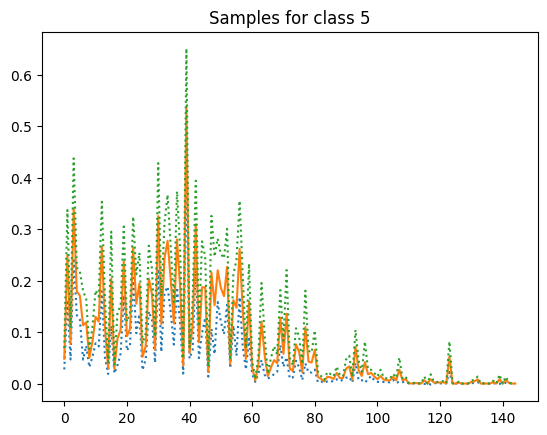

  3%|██▏                                                                       | 2999/100000 [03:32<1:54:31, 14.12it/s]

Iter-3000; D_loss: 0.0014392407611012459; G_loss: -0.8530192971229553; C_loss: 0.10853173583745956


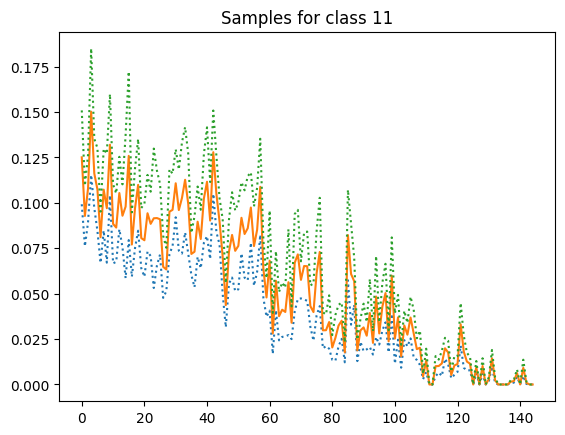

  4%|██▉                                                                       | 4000/100000 [04:48<2:28:45, 10.76it/s]

Iter-4000; D_loss: 0.021787887439131737; G_loss: -1.1601386070251465; C_loss: 0.03850456699728966


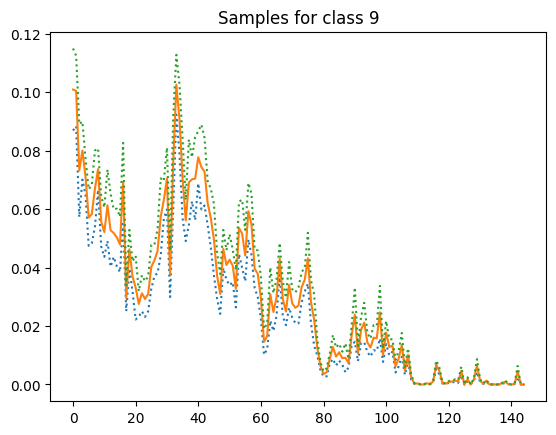

  5%|███▋                                                                      | 5000/100000 [06:08<1:50:06, 14.38it/s]

Iter-5000; D_loss: -0.0011198521824553609; G_loss: -1.4831722974777222; C_loss: 0.06350311636924744


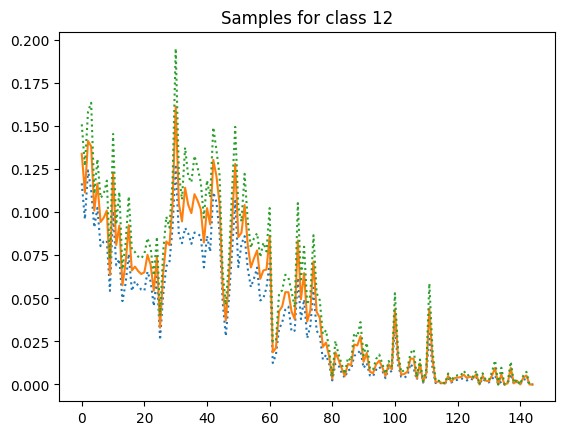

  6%|████▍                                                                     | 5999/100000 [07:18<1:44:43, 14.96it/s]

Iter-6000; D_loss: 0.002030633855611086; G_loss: -1.155485987663269; C_loss: 0.03498639538884163


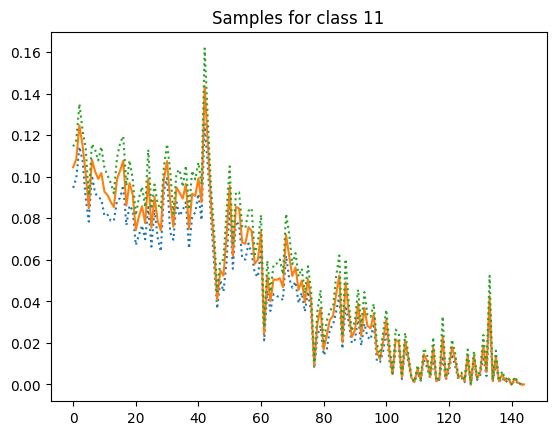

  7%|█████▏                                                                    | 6999/100000 [08:29<2:06:24, 12.26it/s]

Iter-7000; D_loss: 0.0009976265719160438; G_loss: -1.1218645572662354; C_loss: 0.020358465611934662


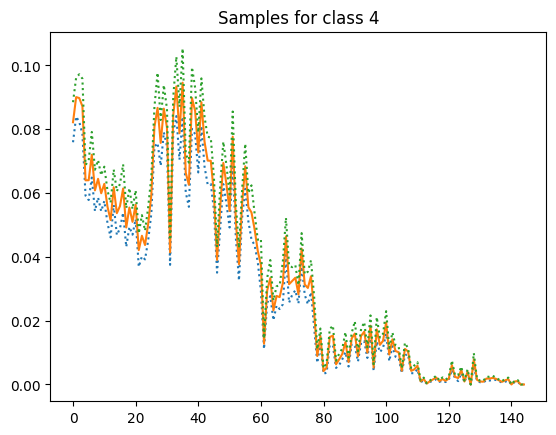

  8%|█████▉                                                                    | 8000/100000 [09:41<1:45:55, 14.48it/s]

Iter-8000; D_loss: 0.0031847914215177298; G_loss: -2.023470640182495; C_loss: 0.02153800055384636


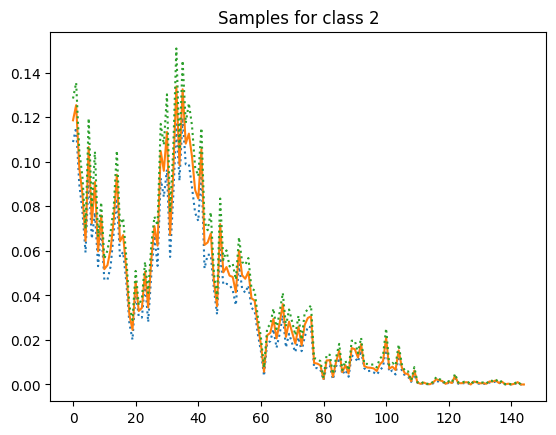

  9%|██████▋                                                                   | 9000/100000 [10:53<1:59:05, 12.73it/s]

Iter-9000; D_loss: 0.01281115971505642; G_loss: -1.7938692569732666; C_loss: 0.016832862049341202


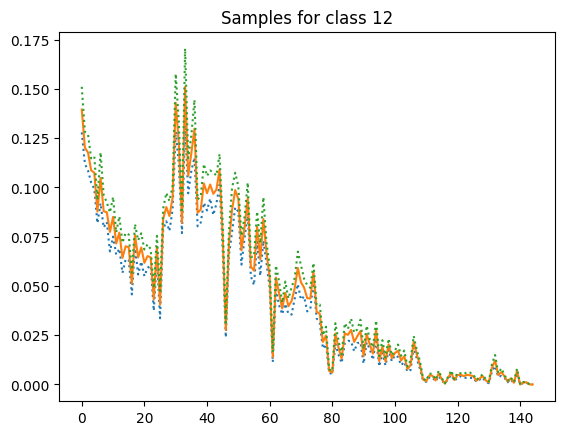

 10%|███████▍                                                                  | 9999/100000 [12:04<1:41:18, 14.81it/s]

Iter-10000; D_loss: 0.05157969519495964; G_loss: -3.020881175994873; C_loss: 0.03377283737063408


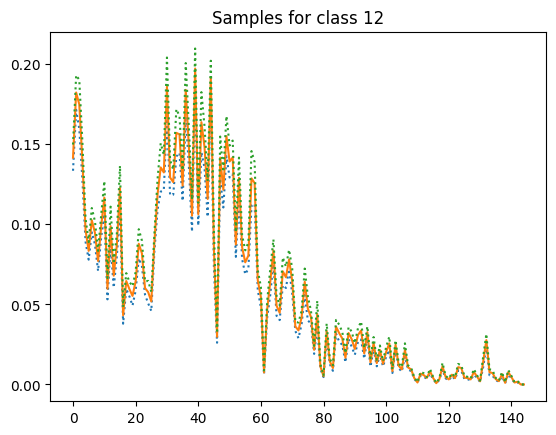

 11%|████████                                                                 | 10999/100000 [13:15<1:36:08, 15.43it/s]

Iter-11000; D_loss: 0.002064824104309082; G_loss: -2.572084426879883; C_loss: 0.05901853367686272


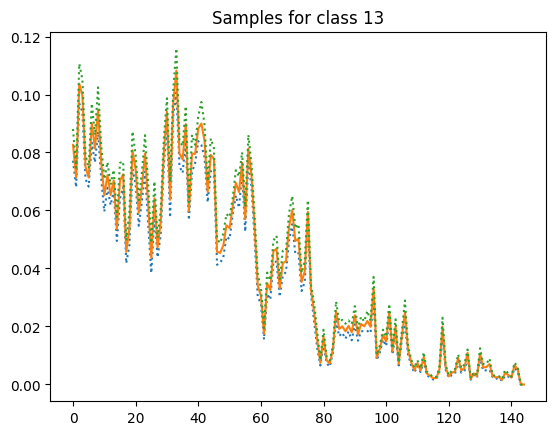

 12%|████████▊                                                                | 11999/100000 [14:26<1:42:42, 14.28it/s]

Iter-12000; D_loss: 0.008283073082566261; G_loss: -2.652226448059082; C_loss: 0.018937889486551285


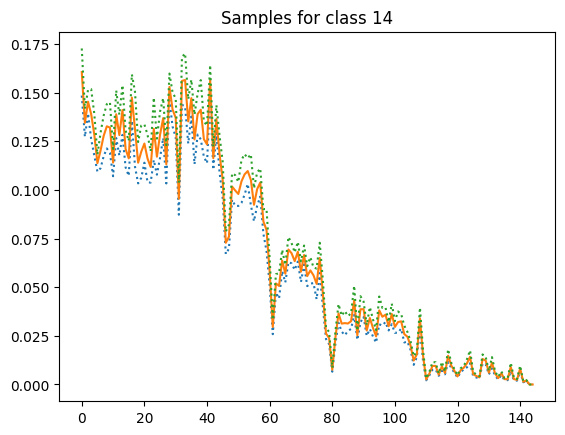

 13%|█████████▍                                                               | 12999/100000 [15:39<1:37:05, 14.93it/s]

Iter-13000; D_loss: 0.000971683650277555; G_loss: -2.618992567062378; C_loss: 0.03934046998620033


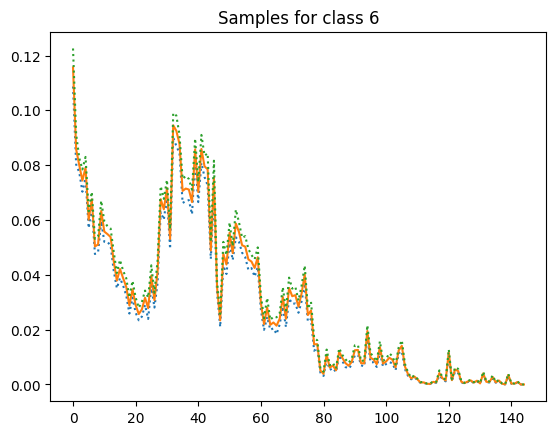

 14%|██████████▏                                                              | 13999/100000 [16:50<1:42:37, 13.97it/s]

Iter-14000; D_loss: 0.011241508647799492; G_loss: -2.278102397918701; C_loss: 0.02750280871987343


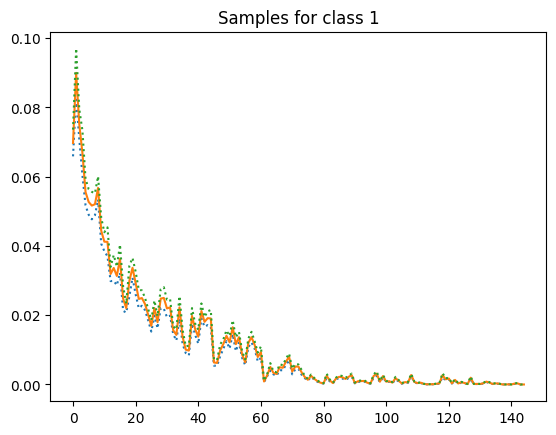

 15%|██████████▉                                                              | 14999/100000 [18:02<1:50:27, 12.83it/s]

Iter-15000; D_loss: 0.007889488711953163; G_loss: -2.454026699066162; C_loss: 0.021398436278104782


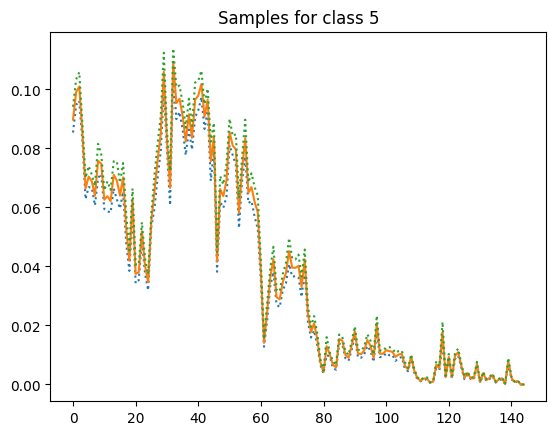

 16%|███████████▋                                                             | 16000/100000 [19:14<1:42:15, 13.69it/s]

Iter-16000; D_loss: 0.1624939739704132; G_loss: -1.6654287576675415; C_loss: 0.04495622590184212


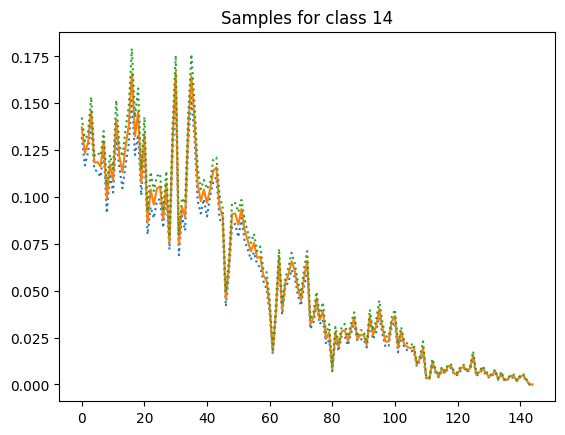

 17%|████████████▍                                                            | 17000/100000 [20:25<1:37:49, 14.14it/s]

Iter-17000; D_loss: 0.0019863974303007126; G_loss: -2.343271255493164; C_loss: 0.08831910043954849


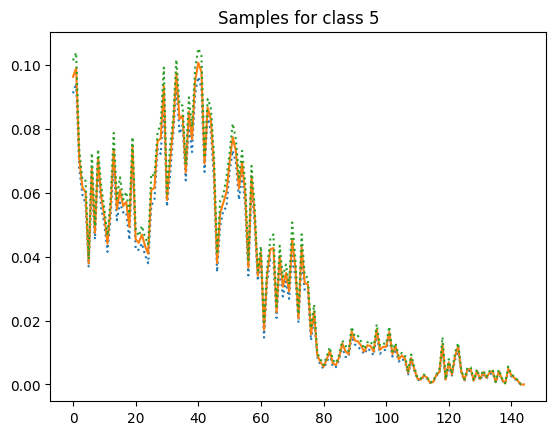

 18%|█████████████▏                                                           | 17999/100000 [21:37<1:30:47, 15.05it/s]

Iter-18000; D_loss: 0.0033099250867962837; G_loss: -2.5540027618408203; C_loss: 0.0276019424200058


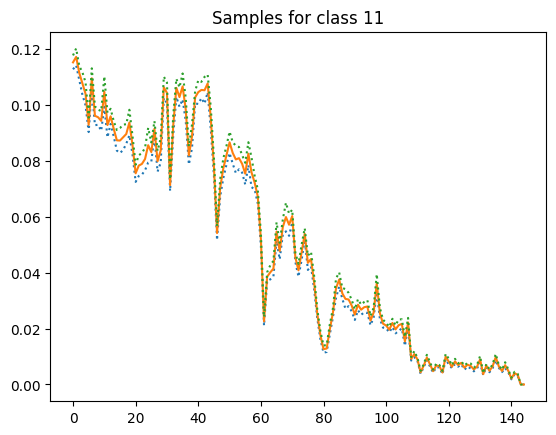

 19%|█████████████▊                                                           | 18999/100000 [22:49<1:41:22, 13.32it/s]

Iter-19000; D_loss: 0.004143712110817432; G_loss: -2.8141400814056396; C_loss: 0.032137222588062286


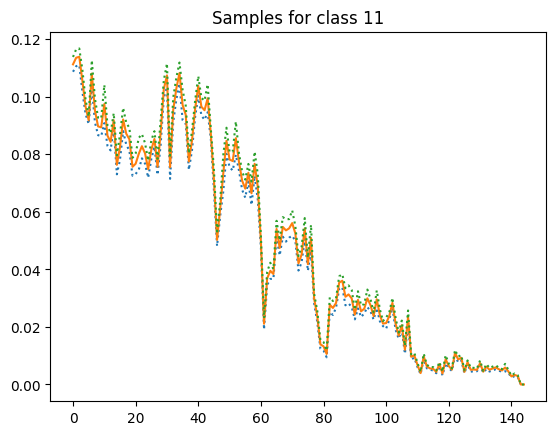

 20%|██████████████▌                                                          | 20000/100000 [24:02<1:34:33, 14.10it/s]

Iter-20000; D_loss: 0.0017574921948835254; G_loss: -2.2765004634857178; C_loss: 0.020803255960345268


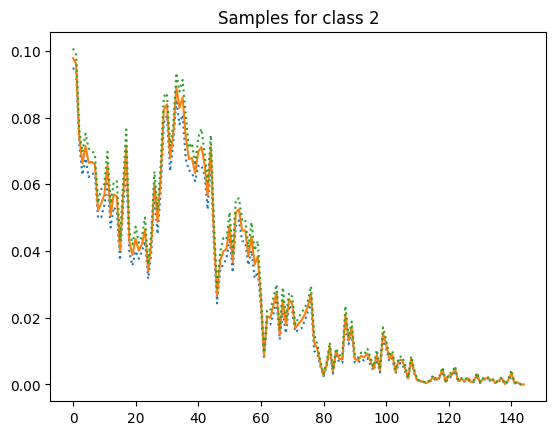

 21%|███████████████▎                                                         | 20999/100000 [25:13<1:38:50, 13.32it/s]

Iter-21000; D_loss: 0.0018593488493934274; G_loss: -2.54753041267395; C_loss: 0.021802935749292374


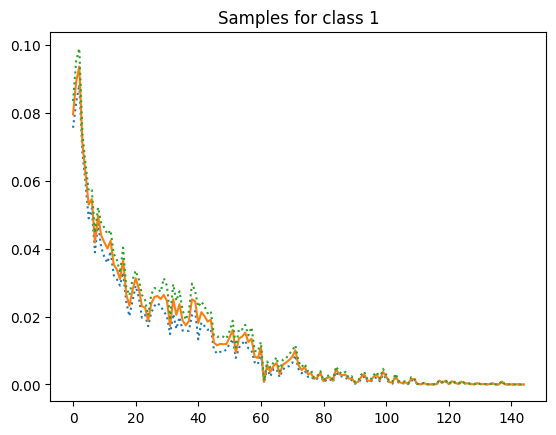

 22%|████████████████                                                         | 22000/100000 [26:27<1:34:27, 13.76it/s]

Iter-22000; D_loss: 0.0006356872618198395; G_loss: -2.6080358028411865; C_loss: 0.032346922904253006


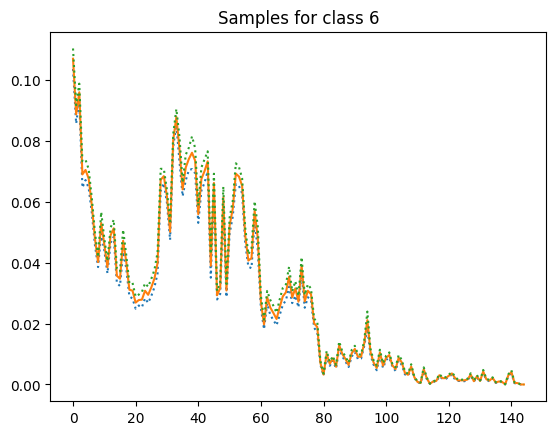

 23%|████████████████▊                                                        | 23000/100000 [27:39<1:42:47, 12.48it/s]

Iter-23000; D_loss: 0.0032659322023391724; G_loss: -1.7860699892044067; C_loss: 0.029334690421819687


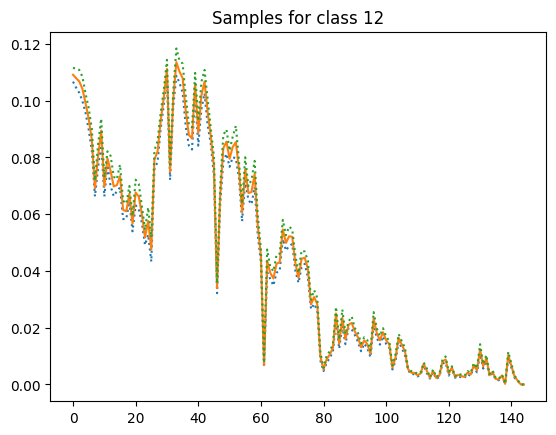

 24%|█████████████████▌                                                       | 23999/100000 [28:50<1:25:35, 14.80it/s]

Iter-24000; D_loss: 0.05386630445718765; G_loss: -2.1523993015289307; C_loss: 0.025001319125294685


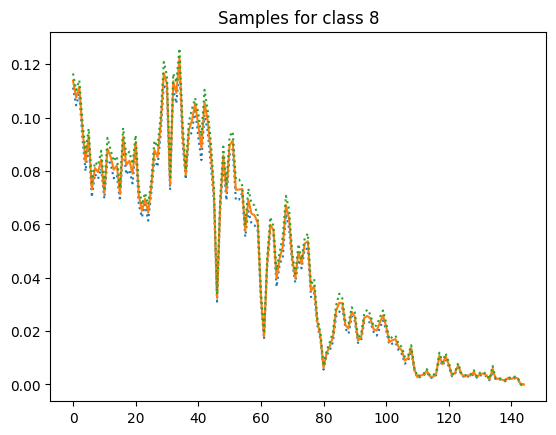

 25%|██████████████████▎                                                      | 25000/100000 [30:03<1:50:38, 11.30it/s]

Iter-25000; D_loss: 0.0006729308515787125; G_loss: -1.745957374572754; C_loss: 0.040124718099832535


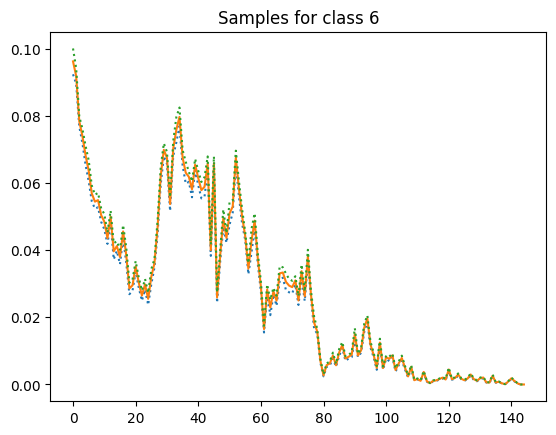

 26%|██████████████████▉                                                      | 26000/100000 [31:17<1:24:59, 14.51it/s]

Iter-26000; D_loss: 0.00019447128579486161; G_loss: -1.7134010791778564; C_loss: 0.01612314209342003


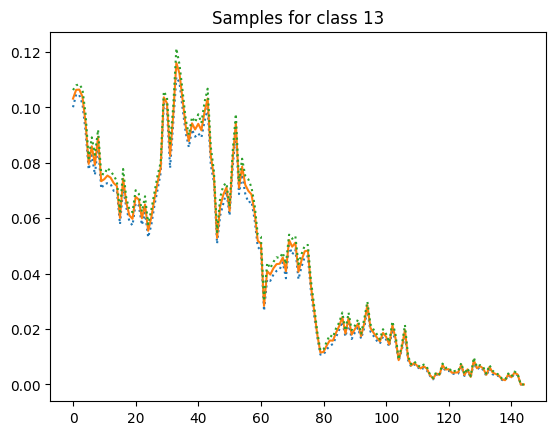

 27%|███████████████████▋                                                     | 27000/100000 [32:29<1:30:16, 13.48it/s]

Iter-27000; D_loss: 0.004649683833122253; G_loss: -2.278365135192871; C_loss: 0.0214263666421175


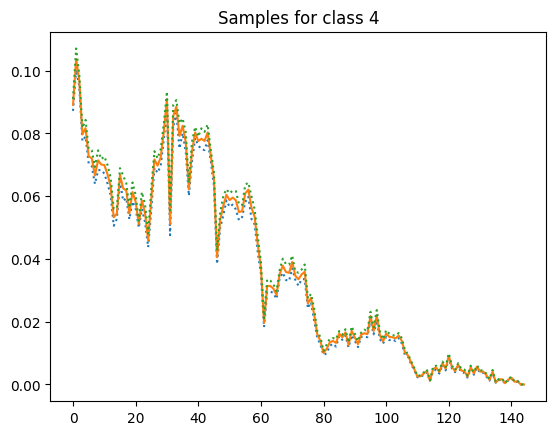

 28%|████████████████████▍                                                    | 27999/100000 [33:43<1:32:49, 12.93it/s]

Iter-28000; D_loss: 0.0014738645404577255; G_loss: -1.8356566429138184; C_loss: 0.02794293500483036


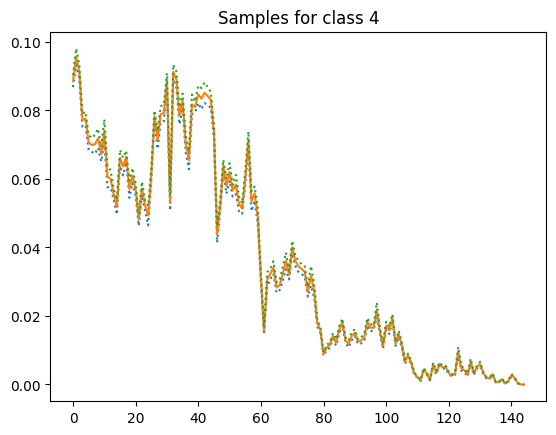

 29%|█████████████████████▏                                                   | 28999/100000 [34:57<1:30:52, 13.02it/s]

Iter-29000; D_loss: 0.0006723411497659981; G_loss: -2.5766775608062744; C_loss: 0.0209162887185812


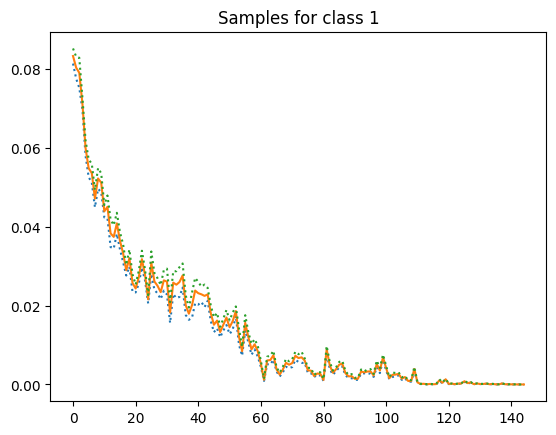

 30%|█████████████████████▉                                                   | 30000/100000 [36:09<1:13:03, 15.97it/s]

Iter-30000; D_loss: -0.012156054377555847; G_loss: -2.387505054473877; C_loss: 0.20445798337459564


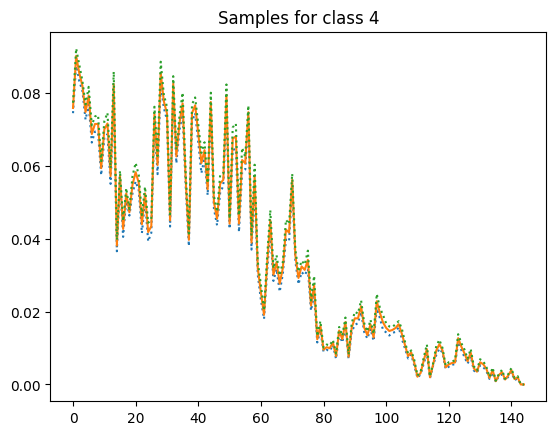

 31%|██████████████████████▋                                                  | 30999/100000 [37:21<1:28:16, 13.03it/s]

Iter-31000; D_loss: 0.0011295684380456805; G_loss: -1.6893870830535889; C_loss: 0.01319489162415266


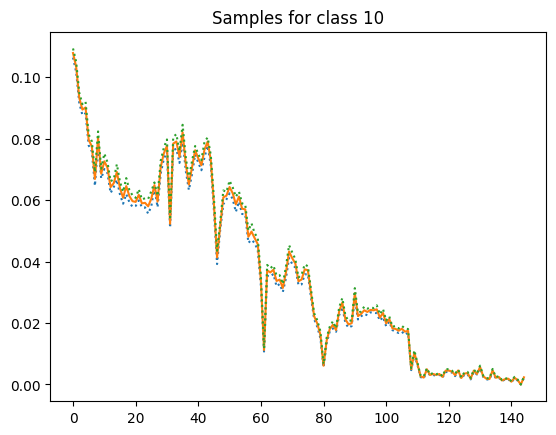

 32%|███████████████████████▎                                                 | 32000/100000 [38:38<1:23:21, 13.60it/s]

Iter-32000; D_loss: 0.0029233512468636036; G_loss: -1.4323347806930542; C_loss: 0.03398631885647774


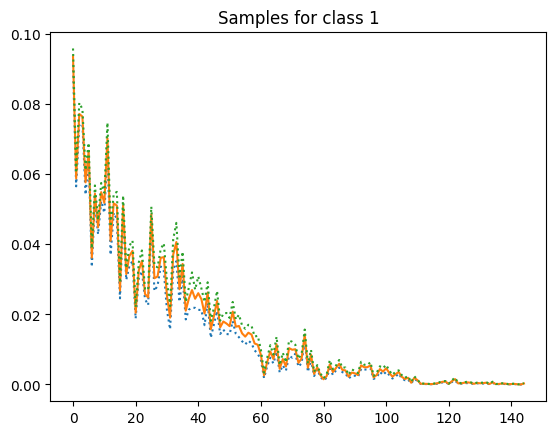

 33%|████████████████████████                                                 | 32999/100000 [39:52<1:23:06, 13.44it/s]

Iter-33000; D_loss: 0.0010934516321867704; G_loss: -1.4454715251922607; C_loss: 0.022623518481850624


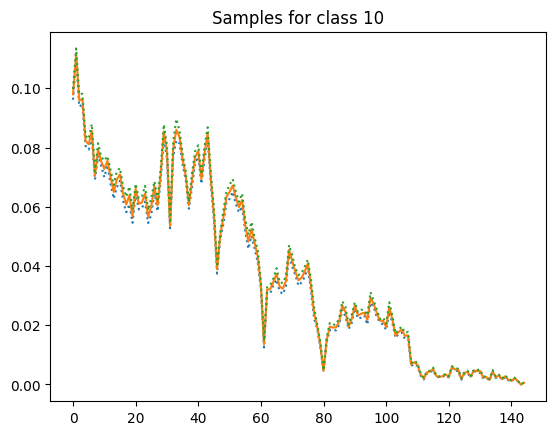

 34%|████████████████████████▊                                                | 34000/100000 [41:06<1:19:42, 13.80it/s]

Iter-34000; D_loss: 0.004236292559653521; G_loss: -1.5283795595169067; C_loss: 0.02673621103167534


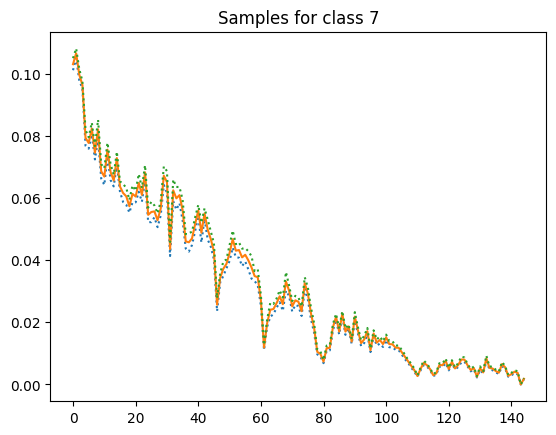

 35%|█████████████████████████▌                                               | 35000/100000 [42:21<1:13:50, 14.67it/s]

Iter-35000; D_loss: 0.008718809112906456; G_loss: -1.2860376834869385; C_loss: 0.023059746250510216


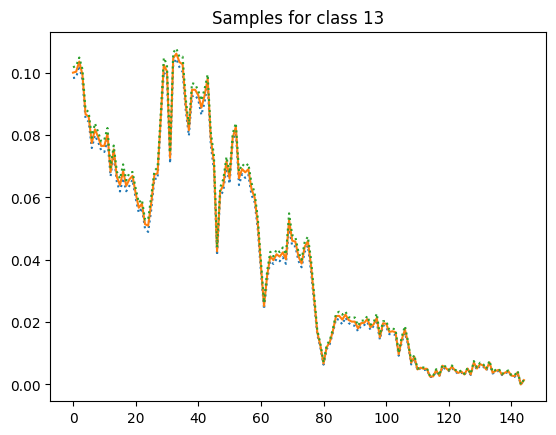

 36%|██████████████████████████▎                                              | 36000/100000 [43:36<1:27:14, 12.23it/s]

Iter-36000; D_loss: 0.0009931104723364115; G_loss: -1.0447680950164795; C_loss: 0.01583520509302616


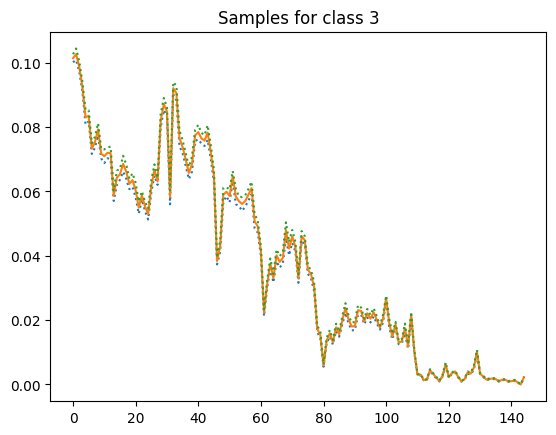

 37%|███████████████████████████                                              | 36999/100000 [44:50<1:12:44, 14.44it/s]

Iter-37000; D_loss: 0.002818212378770113; G_loss: -1.0862467288970947; C_loss: 0.027424119412899017


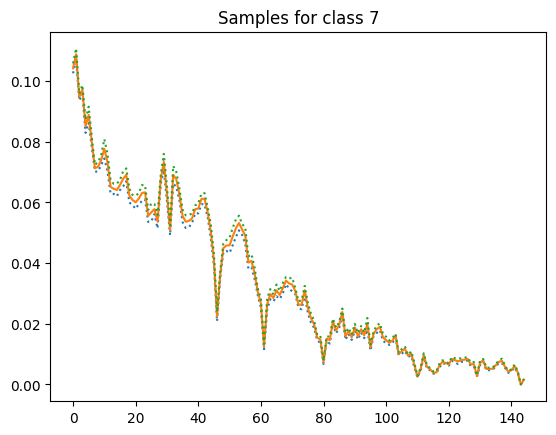

 38%|███████████████████████████▋                                             | 37999/100000 [46:05<1:16:31, 13.50it/s]

Iter-38000; D_loss: 0.005312299355864525; G_loss: -1.3254148960113525; C_loss: 0.011419017799198627


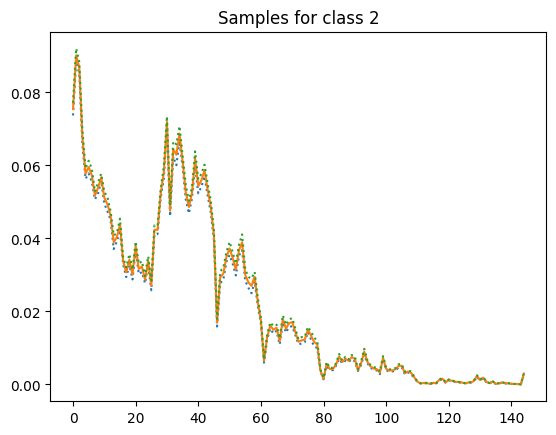

 39%|████████████████████████████▍                                            | 38999/100000 [47:19<1:09:40, 14.59it/s]

Iter-39000; D_loss: 0.00263125728815794; G_loss: -0.8847607374191284; C_loss: 0.017376553267240524


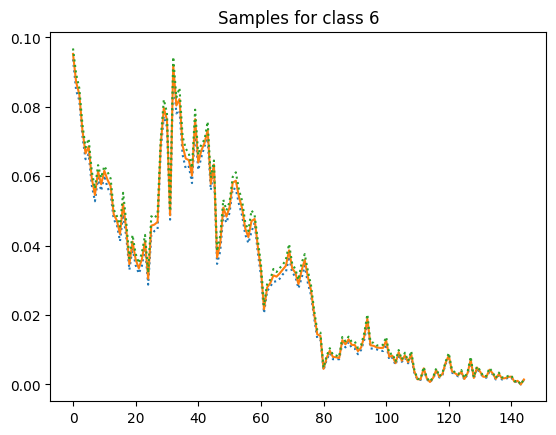

 40%|█████████████████████████████▏                                           | 39999/100000 [48:31<1:12:20, 13.82it/s]

Iter-40000; D_loss: 0.002873031422495842; G_loss: -0.35642173886299133; C_loss: 0.04831143841147423


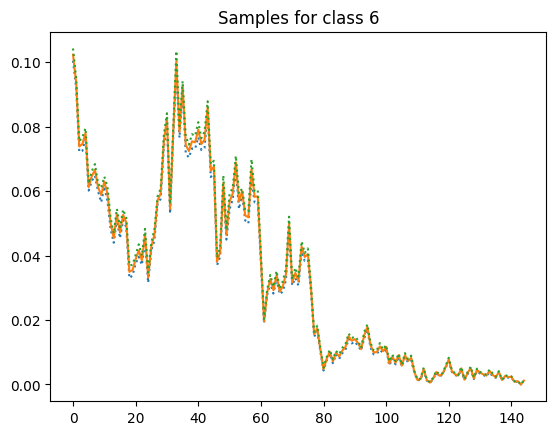

 41%|█████████████████████████████▉                                           | 40999/100000 [49:43<1:19:36, 12.35it/s]

Iter-41000; D_loss: 0.00018577289301902056; G_loss: -0.327380508184433; C_loss: 0.028305724263191223


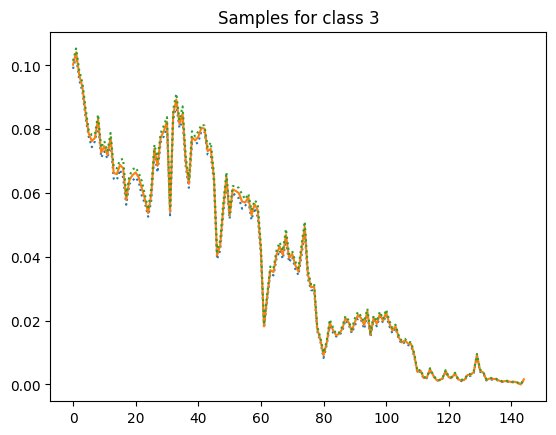

 42%|██████████████████████████████▋                                          | 41999/100000 [50:56<1:13:43, 13.11it/s]

Iter-42000; D_loss: 0.0011090489570051432; G_loss: 0.374733567237854; C_loss: 0.03145943582057953


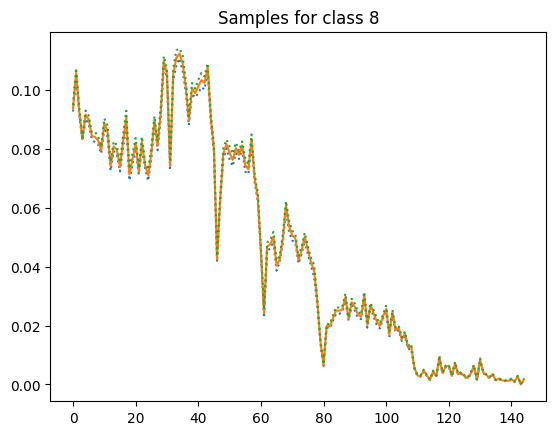

 43%|███████████████████████████████▍                                         | 43000/100000 [52:08<1:01:06, 15.55it/s]

Iter-43000; D_loss: 0.0002768890408333391; G_loss: 0.25755682587623596; C_loss: 0.02487354539334774


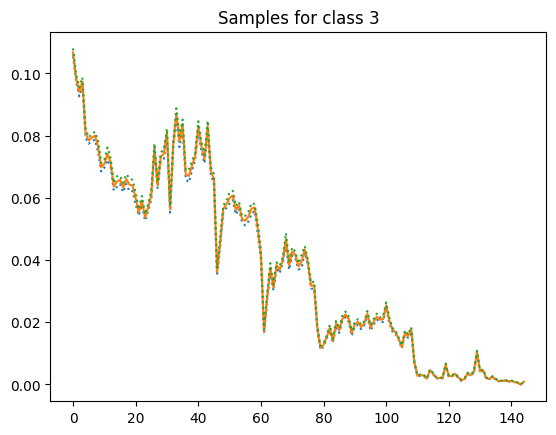

 44%|████████████████████████████████                                         | 44000/100000 [53:20<1:20:35, 11.58it/s]

Iter-44000; D_loss: 0.006993889342993498; G_loss: 0.37627530097961426; C_loss: 0.015336372889578342


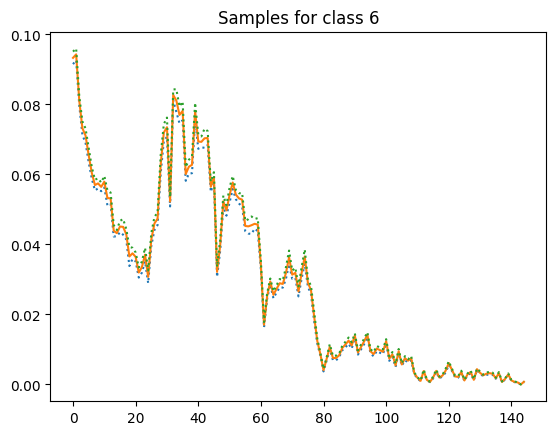

 45%|████████████████████████████████▊                                        | 45000/100000 [54:34<1:03:52, 14.35it/s]

Iter-45000; D_loss: 0.00036827410804107785; G_loss: 0.097202368080616; C_loss: 0.019680572673678398


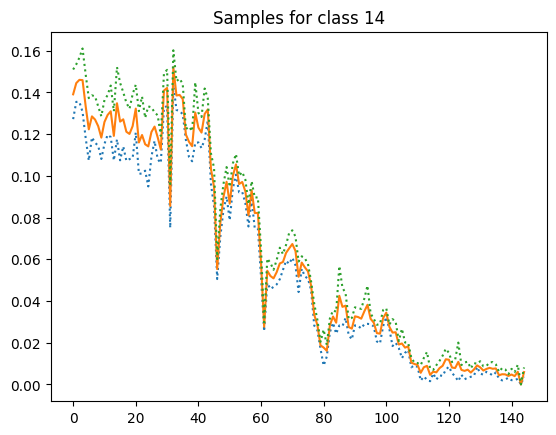

 46%|█████████████████████████████████▌                                       | 45999/100000 [55:48<1:03:36, 14.15it/s]

Iter-46000; D_loss: 0.0014634649269282818; G_loss: 0.2041987031698227; C_loss: 0.02790830470621586


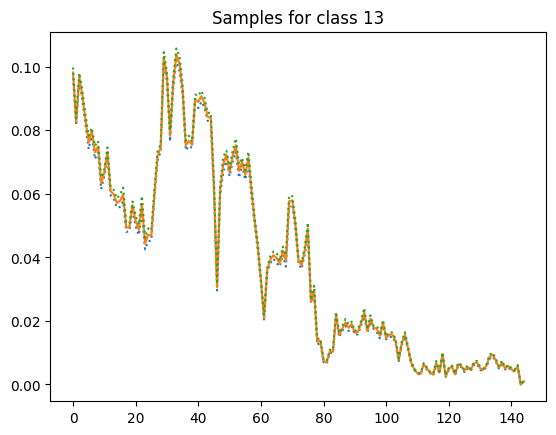

 47%|██████████████████████████████████▎                                      | 46999/100000 [56:59<1:01:57, 14.26it/s]

Iter-47000; D_loss: 0.0009780956897884607; G_loss: -0.052941568195819855; C_loss: 0.030280521139502525


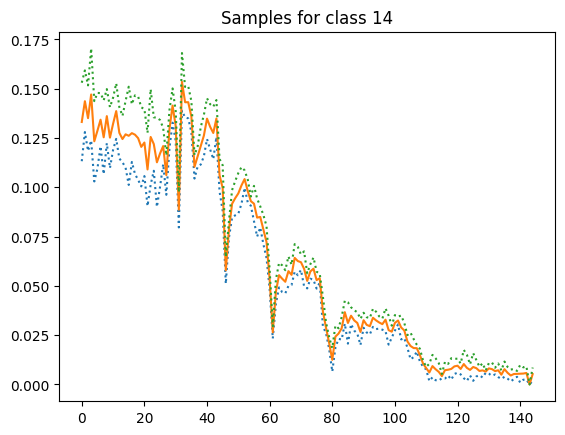

 48%|███████████████████████████████████                                      | 47999/100000 [58:13<1:03:22, 13.68it/s]

Iter-48000; D_loss: 0.0009915807750076056; G_loss: -0.6108999848365784; C_loss: 0.027529634535312653


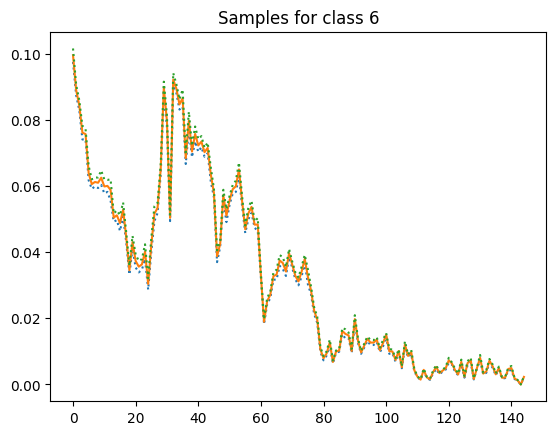

 49%|███████████████████████████████████▊                                     | 48999/100000 [59:26<1:01:00, 13.93it/s]

Iter-49000; D_loss: 0.004180944990366697; G_loss: -0.5917300581932068; C_loss: 0.02085772529244423


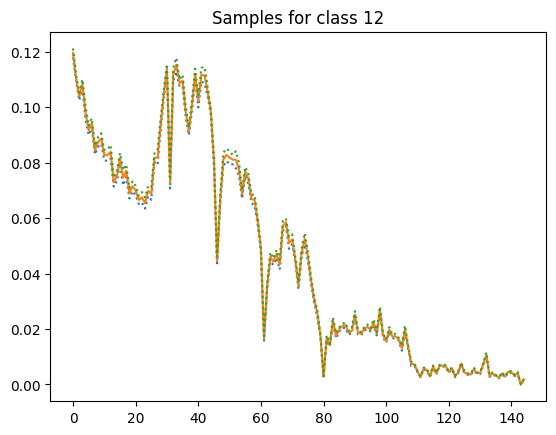

 50%|███████████████████████████████████▌                                   | 50000/100000 [1:00:38<1:01:24, 13.57it/s]

Iter-50000; D_loss: 0.011505942791700363; G_loss: -1.1558334827423096; C_loss: 0.024657048285007477


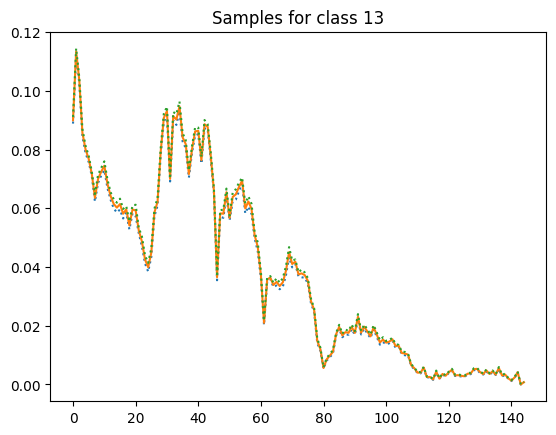

 51%|████████████████████████████████████▏                                  | 50999/100000 [1:01:53<1:10:14, 11.63it/s]

Iter-51000; D_loss: 0.00037665056879632175; G_loss: -1.4355721473693848; C_loss: 0.023808900266885757


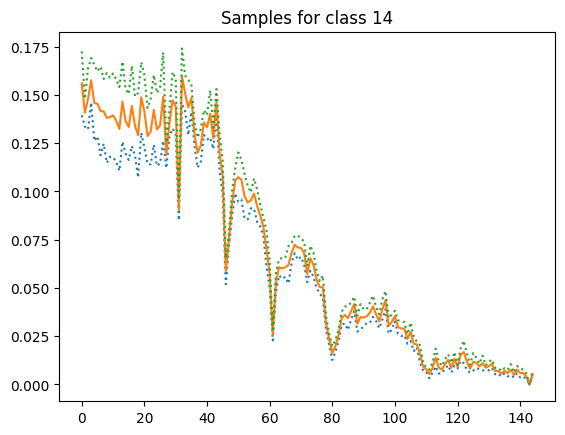

 52%|████████████████████████████████████▉                                  | 51999/100000 [1:03:08<1:09:09, 11.57it/s]

Iter-52000; D_loss: 0.0007169635500758886; G_loss: -1.712348222732544; C_loss: 0.01889376901090145


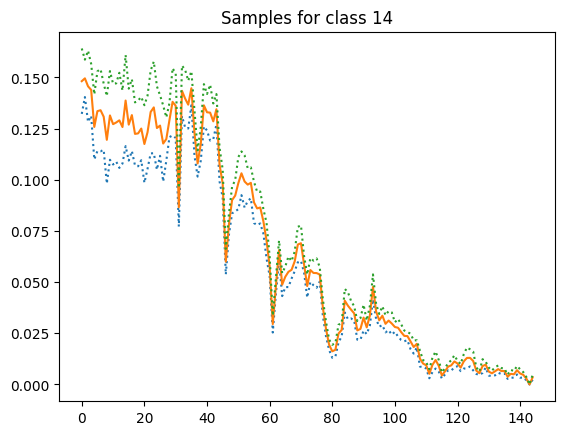

 53%|██████████████████████████████████████▋                                  | 53000/100000 [1:04:22<54:19, 14.42it/s]

Iter-53000; D_loss: 0.0012384564615786076; G_loss: -1.964048147201538; C_loss: 0.0264048520475626


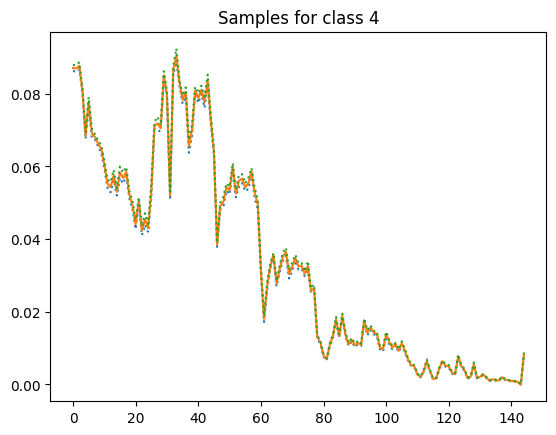

 54%|███████████████████████████████████████▍                                 | 54000/100000 [1:05:35<58:32, 13.10it/s]

Iter-54000; D_loss: -0.010371705517172813; G_loss: -1.7381716966629028; C_loss: 0.33168530464172363


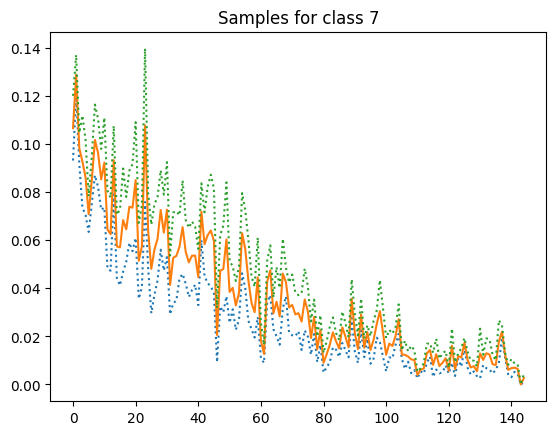

 55%|████████████████████████████████████████▏                                | 55000/100000 [1:06:48<53:46, 13.95it/s]

Iter-55000; D_loss: 0.004113402683287859; G_loss: -2.0274949073791504; C_loss: 0.01913854479789734


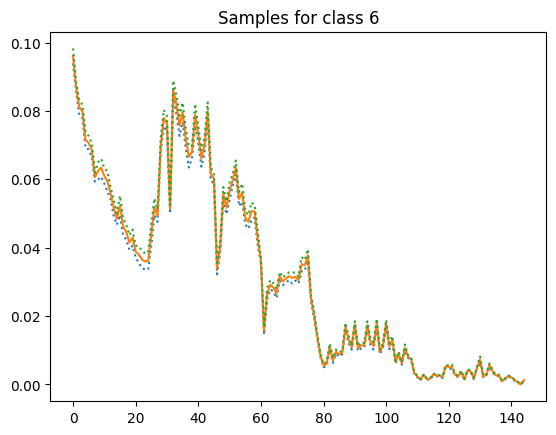

 56%|████████████████████████████████████████▉                                | 55999/100000 [1:08:01<51:32, 14.23it/s]

Iter-56000; D_loss: 0.001255444367416203; G_loss: -1.9979268312454224; C_loss: 0.022566989064216614


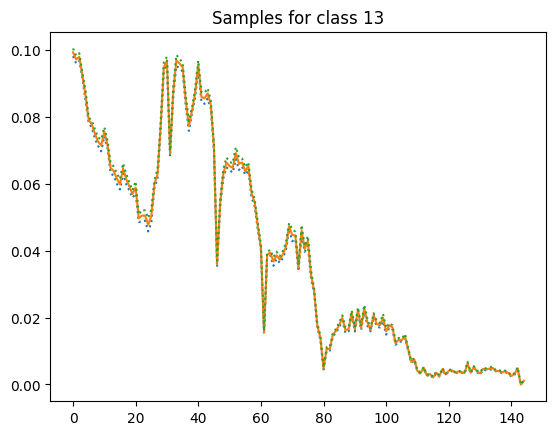

 57%|█████████████████████████████████████████▌                               | 57000/100000 [1:09:13<48:00, 14.93it/s]

Iter-57000; D_loss: 0.000612819567322731; G_loss: -2.378399610519409; C_loss: 0.018925853073596954


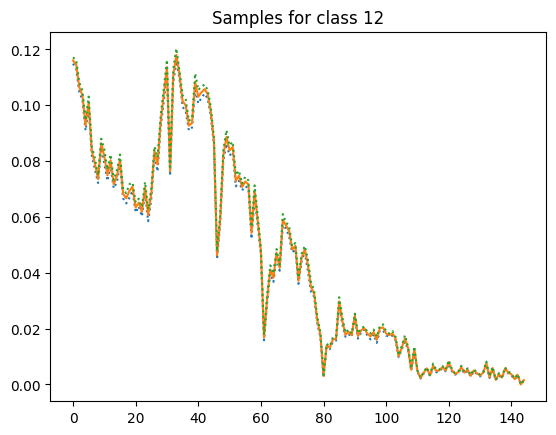

 58%|██████████████████████████████████████████▎                              | 57999/100000 [1:10:26<51:36, 13.56it/s]

Iter-58000; D_loss: 0.0011008617002516985; G_loss: -2.9111311435699463; C_loss: 0.019341131672263145


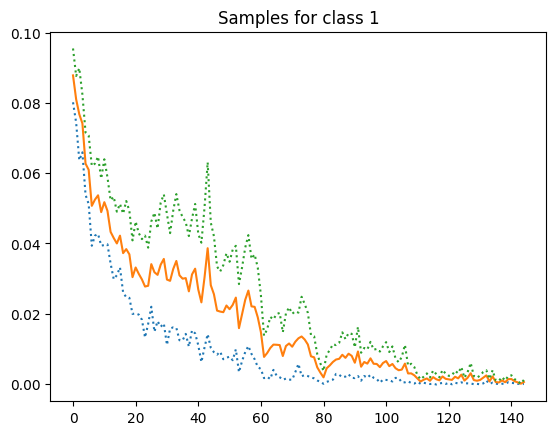

 59%|███████████████████████████████████████████                              | 59000/100000 [1:11:39<50:05, 13.64it/s]

Iter-59000; D_loss: 0.0029817884787917137; G_loss: -3.0375874042510986; C_loss: 0.027454305440187454


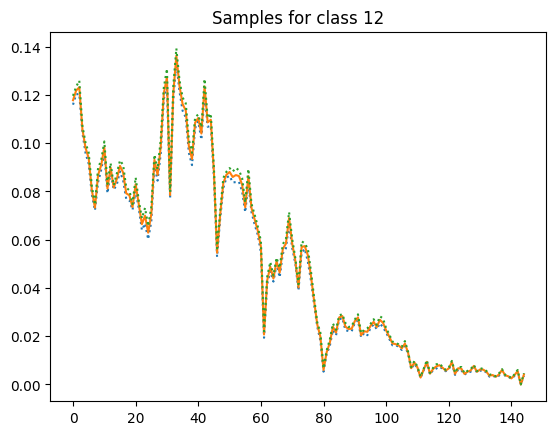

 60%|███████████████████████████████████████████▊                             | 59999/100000 [1:12:52<45:28, 14.66it/s]

Iter-60000; D_loss: 0.01020755060017109; G_loss: -2.6542060375213623; C_loss: 0.021976789459586143


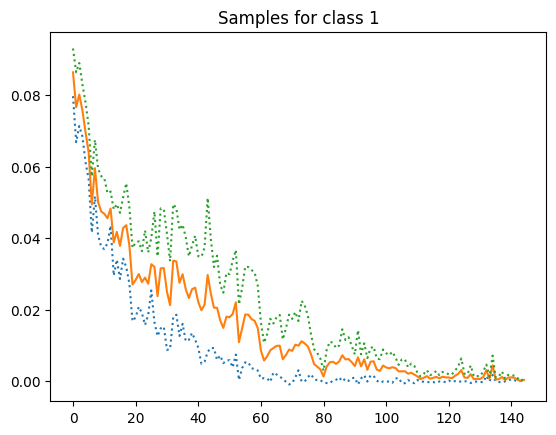

 61%|████████████████████████████████████████████▌                            | 60999/100000 [1:14:05<46:48, 13.89it/s]

Iter-61000; D_loss: 0.0005872593028470874; G_loss: -2.5000200271606445; C_loss: 0.022085491567850113


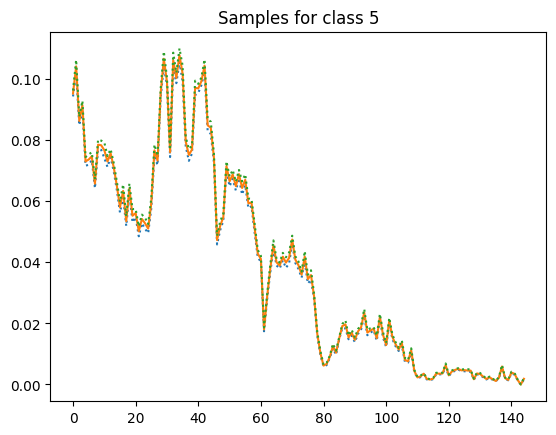

 62%|█████████████████████████████████████████████▎                           | 61999/100000 [1:15:18<42:11, 15.01it/s]

Iter-62000; D_loss: 0.0003828237531706691; G_loss: -2.2673850059509277; C_loss: 0.023728370666503906


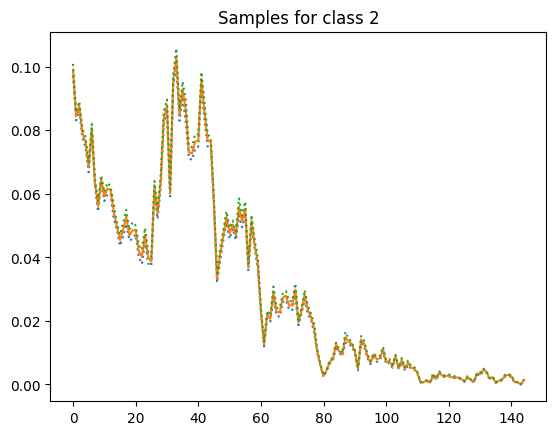

 63%|█████████████████████████████████████████████▉                           | 63000/100000 [1:16:31<39:09, 15.75it/s]

Iter-63000; D_loss: -0.0005893633933737874; G_loss: -1.7299267053604126; C_loss: 0.025312386453151703


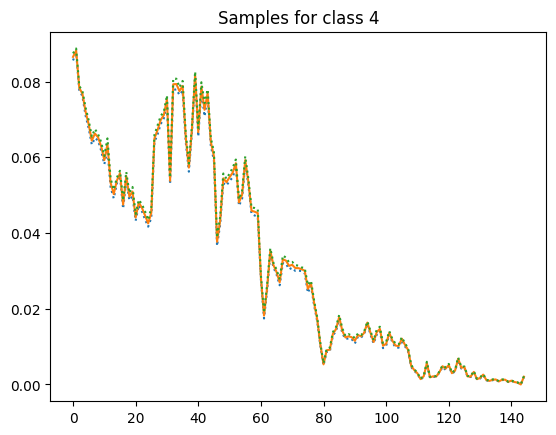

 64%|██████████████████████████████████████████████▋                          | 63999/100000 [1:17:44<47:01, 12.76it/s]

Iter-64000; D_loss: -0.0019538996275514364; G_loss: -2.1522159576416016; C_loss: 0.06039413809776306


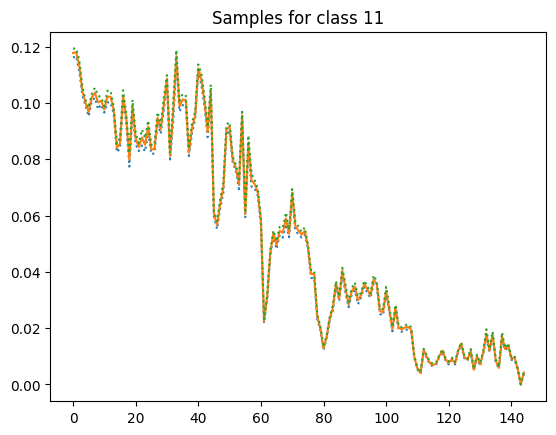

 65%|███████████████████████████████████████████████▍                         | 65000/100000 [1:18:59<43:11, 13.51it/s]

Iter-65000; D_loss: -0.0005696646403521299; G_loss: -1.0749398469924927; C_loss: 0.06396247446537018


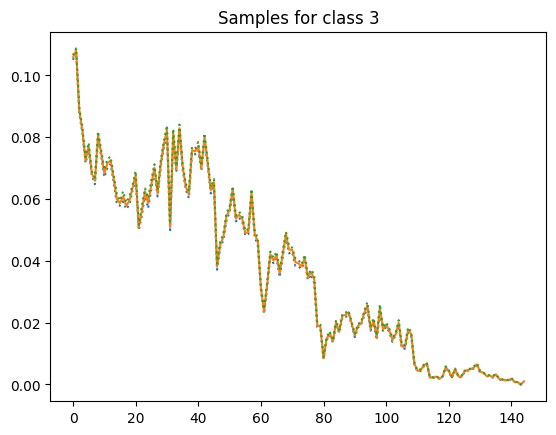

 66%|████████████████████████████████████████████████▏                        | 66000/100000 [1:20:12<44:34, 12.71it/s]

Iter-66000; D_loss: -0.0014263878110796213; G_loss: -0.8363264203071594; C_loss: 0.01936197094619274


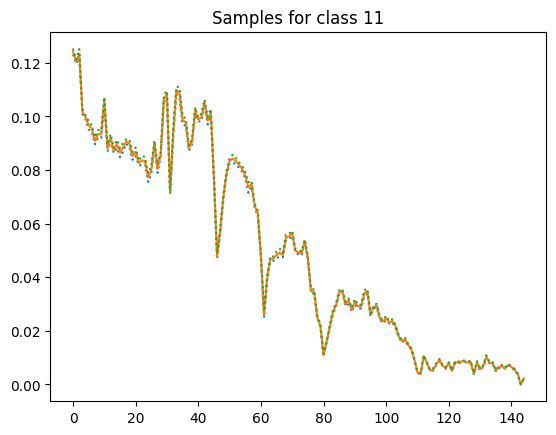

 67%|████████████████████████████████████████████████▉                        | 66999/100000 [1:21:24<39:14, 14.02it/s]

Iter-67000; D_loss: 0.004303528927266598; G_loss: -0.8709011077880859; C_loss: 0.029356982558965683


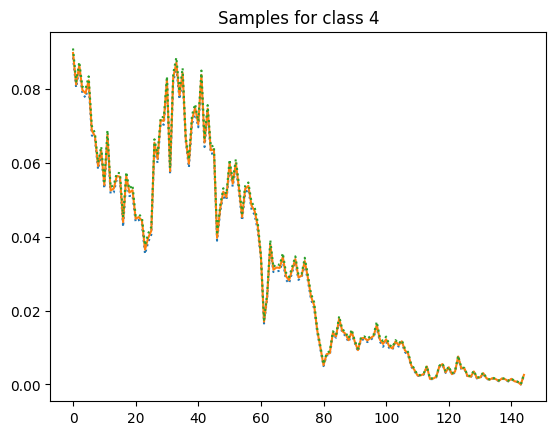

 68%|█████████████████████████████████████████████████▋                       | 68000/100000 [1:22:38<34:23, 15.51it/s]

Iter-68000; D_loss: -0.0029263535980135202; G_loss: -1.2229562997817993; C_loss: 0.041819363832473755


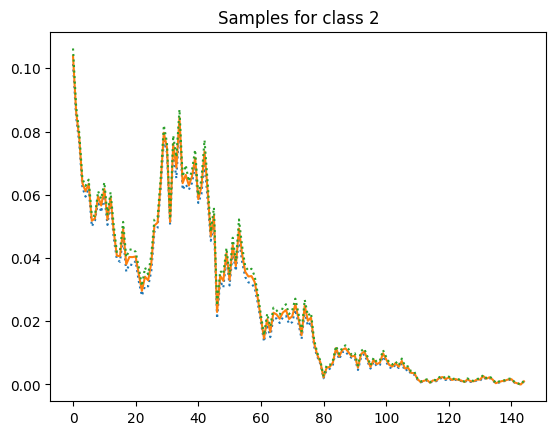

 69%|██████████████████████████████████████████████████▎                      | 69000/100000 [1:23:54<36:59, 13.97it/s]

Iter-69000; D_loss: -0.001498091733083129; G_loss: -1.530195713043213; C_loss: 0.07414241880178452


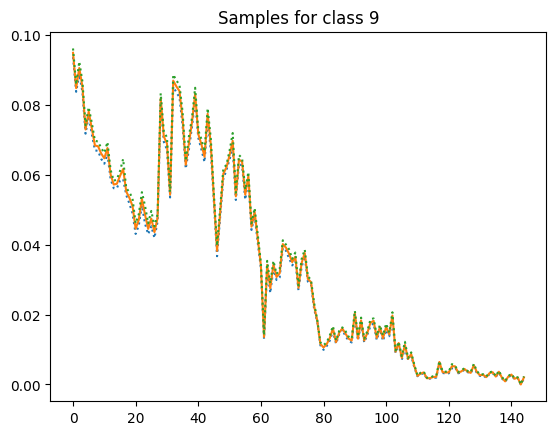

 70%|███████████████████████████████████████████████████                      | 69999/100000 [1:25:05<35:54, 13.93it/s]

Iter-70000; D_loss: 0.002276233397424221; G_loss: -1.56689453125; C_loss: 0.012443667277693748


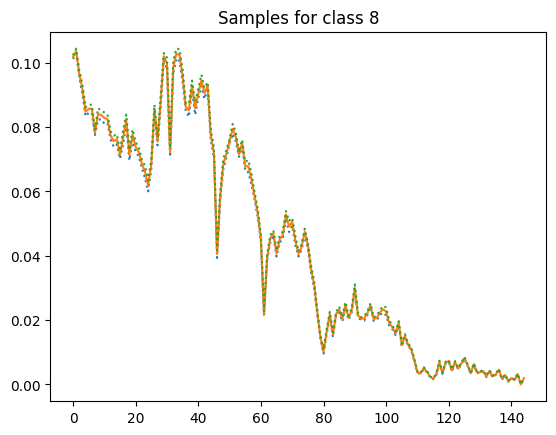

 71%|███████████████████████████████████████████████████▊                     | 71000/100000 [1:26:20<35:05, 13.77it/s]

Iter-71000; D_loss: 0.001142021268606186; G_loss: -0.7817654609680176; C_loss: 0.016951927915215492


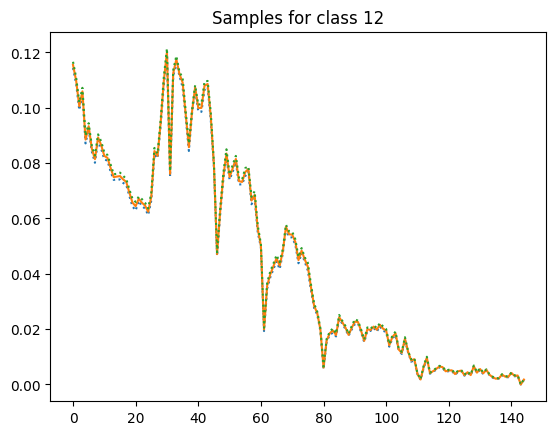

 72%|████████████████████████████████████████████████████▌                    | 72000/100000 [1:27:33<32:18, 14.44it/s]

Iter-72000; D_loss: 0.0012873923406004906; G_loss: -1.641081690788269; C_loss: 0.021358564496040344


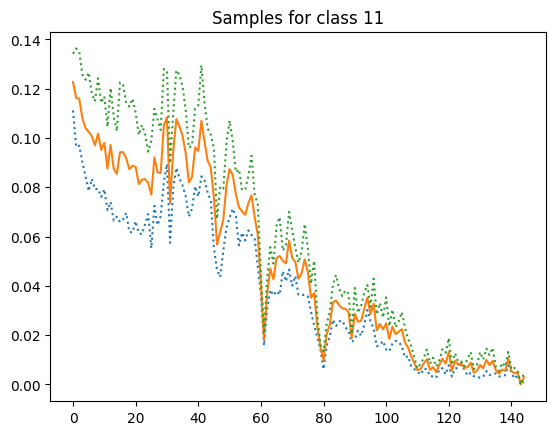

 73%|█████████████████████████████████████████████████████▎                   | 72999/100000 [1:28:44<36:16, 12.40it/s]

Iter-73000; D_loss: 0.002037945669144392; G_loss: -1.8587864637374878; C_loss: 0.025173434987664223


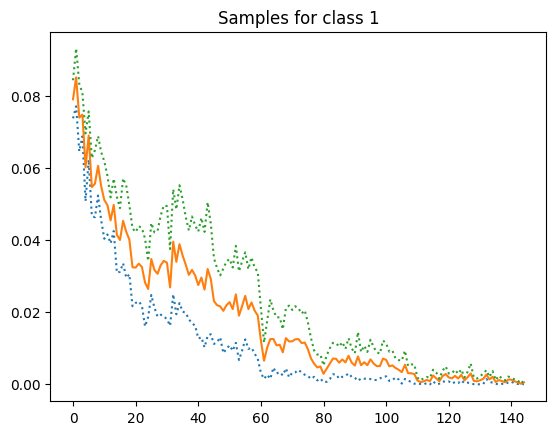

 74%|██████████████████████████████████████████████████████                   | 74000/100000 [1:29:58<28:32, 15.18it/s]

Iter-74000; D_loss: -0.00058849120978266; G_loss: -1.4276049137115479; C_loss: 0.040775496512651443


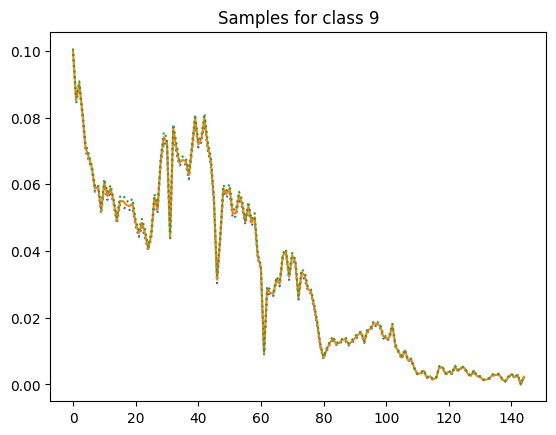

 75%|██████████████████████████████████████████████████████▋                  | 74999/100000 [1:31:11<28:41, 14.53it/s]

Iter-75000; D_loss: 0.006035908125340939; G_loss: -1.126991629600525; C_loss: 0.01459544152021408


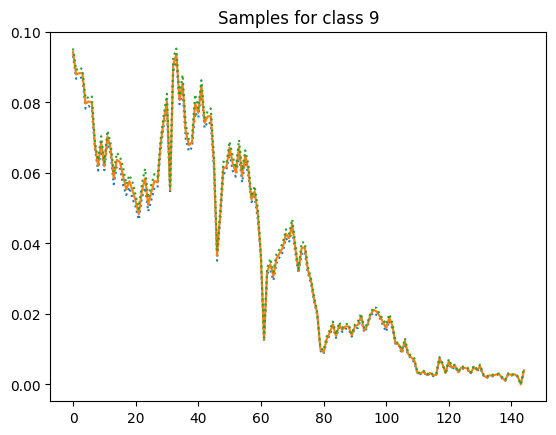

 76%|███████████████████████████████████████████████████████▍                 | 75999/100000 [1:32:21<29:14, 13.68it/s]

Iter-76000; D_loss: 2.0541890989989042e-05; G_loss: -1.614629864692688; C_loss: 0.0276790764182806


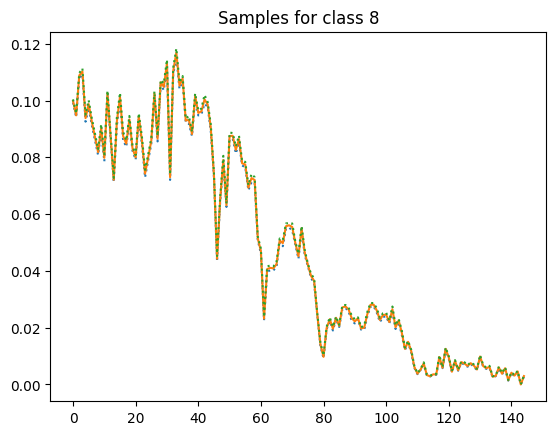

 77%|████████████████████████████████████████████████████████▏                | 77000/100000 [1:33:35<34:02, 11.26it/s]

Iter-77000; D_loss: 0.004464225843548775; G_loss: -1.3326655626296997; C_loss: 0.020130392163991928


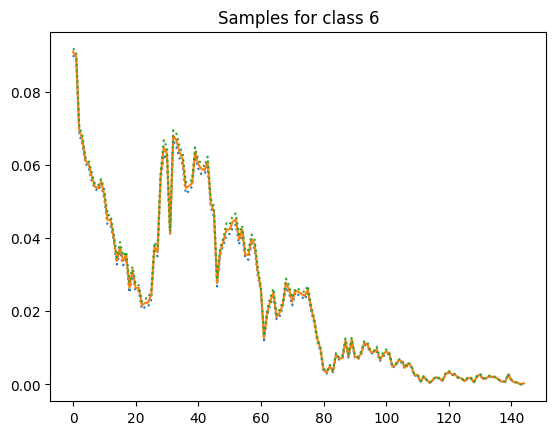

 78%|████████████████████████████████████████████████████████▉                | 78000/100000 [1:34:48<27:17, 13.44it/s]

Iter-78000; D_loss: -0.0015622504288330674; G_loss: -1.38850736618042; C_loss: 0.013726191595196724


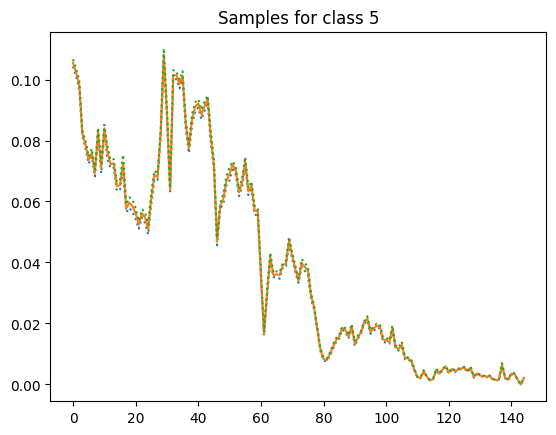

 79%|█████████████████████████████████████████████████████████▋               | 79000/100000 [1:36:01<23:53, 14.65it/s]

Iter-79000; D_loss: 0.0022651776671409607; G_loss: -1.0987815856933594; C_loss: 0.021886516362428665


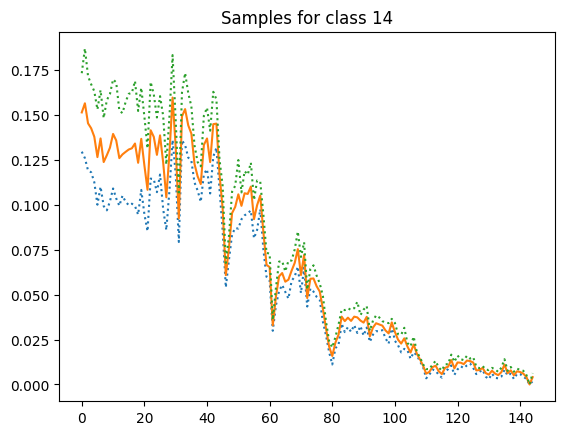

 80%|██████████████████████████████████████████████████████████▍              | 80000/100000 [1:37:13<25:39, 12.99it/s]

Iter-80000; D_loss: -0.0017303565982729197; G_loss: -0.495286226272583; C_loss: 0.027187678962945938


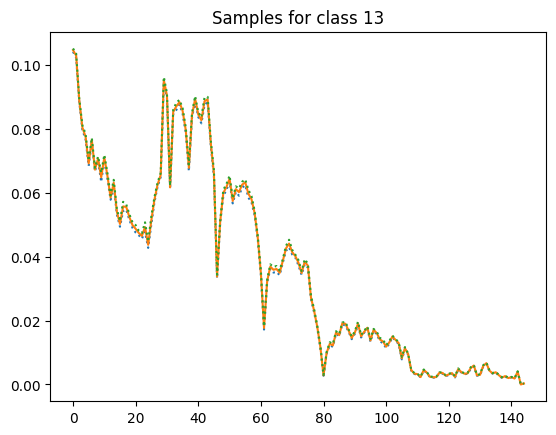

 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [1:38:26<21:48, 14.52it/s]

Iter-81000; D_loss: 0.014231985434889793; G_loss: -0.7645595073699951; C_loss: 0.033130597323179245


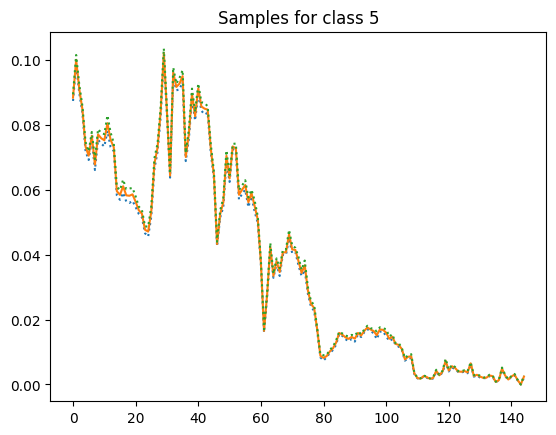

 82%|███████████████████████████████████████████████████████████▊             | 82000/100000 [1:39:41<22:46, 13.17it/s]

Iter-82000; D_loss: -0.0005634606350213289; G_loss: -0.6833383440971375; C_loss: 0.0314980074763298


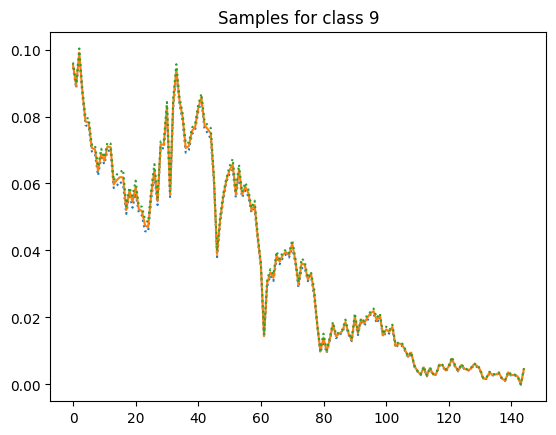

 83%|████████████████████████████████████████████████████████████▌            | 83000/100000 [1:40:54<21:06, 13.42it/s]

Iter-83000; D_loss: 0.011784795671701431; G_loss: -0.5690255165100098; C_loss: 0.02514050342142582


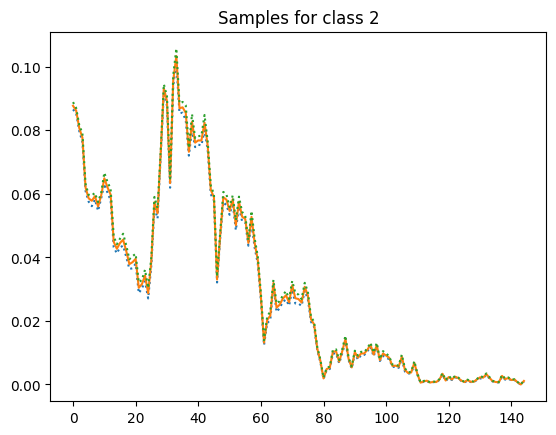

 84%|█████████████████████████████████████████████████████████████▎           | 84000/100000 [1:42:07<19:20, 13.79it/s]

Iter-84000; D_loss: 5.4004136472940445e-05; G_loss: -0.5328105092048645; C_loss: 0.012623981572687626


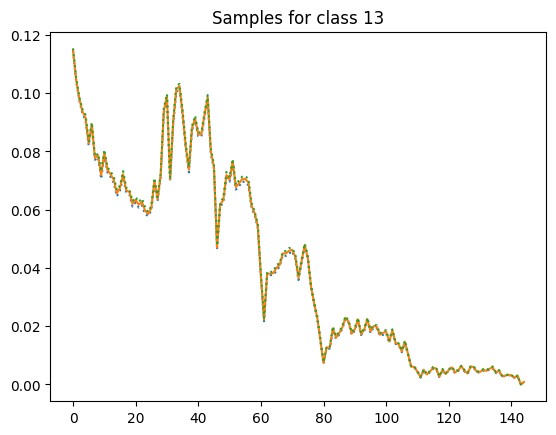

 85%|██████████████████████████████████████████████████████████████           | 85000/100000 [1:43:19<16:27, 15.19it/s]

Iter-85000; D_loss: 0.0005154628306627274; G_loss: -0.464494526386261; C_loss: 0.038155198097229004


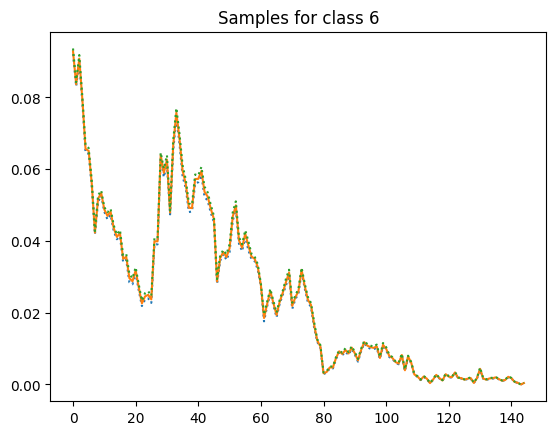

 86%|██████████████████████████████████████████████████████████████▊          | 85999/100000 [1:44:31<17:07, 13.63it/s]

Iter-86000; D_loss: -0.0012388174654915929; G_loss: -0.14028994739055634; C_loss: 0.02306327410042286


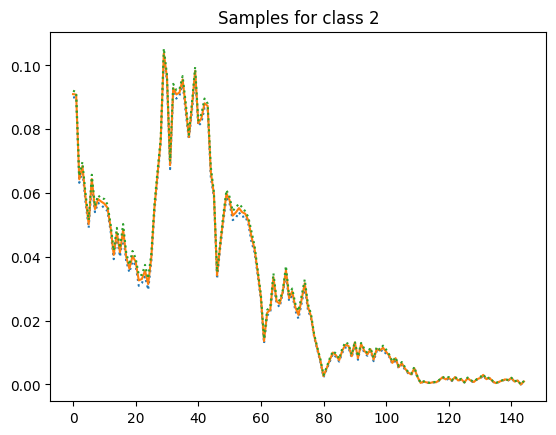

 87%|███████████████████████████████████████████████████████████████▌         | 86999/100000 [1:45:45<14:43, 14.72it/s]

Iter-87000; D_loss: 0.001108044758439064; G_loss: 0.08592497557401657; C_loss: 0.02003425545990467


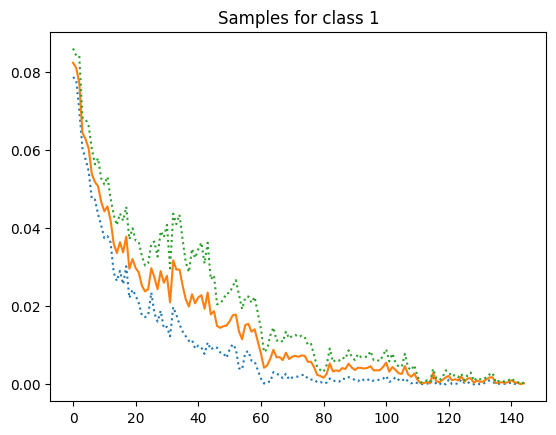

 88%|████████████████████████████████████████████████████████████████▏        | 88000/100000 [1:46:59<13:00, 15.38it/s]

Iter-88000; D_loss: 0.0011225184425711632; G_loss: 0.09622113406658173; C_loss: 0.020315591245889664


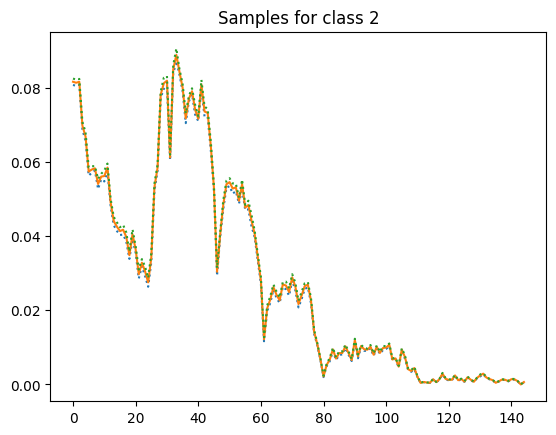

 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [1:48:11<13:21, 13.73it/s]

Iter-89000; D_loss: -0.000791451777331531; G_loss: 0.5332211852073669; C_loss: 0.014034690335392952


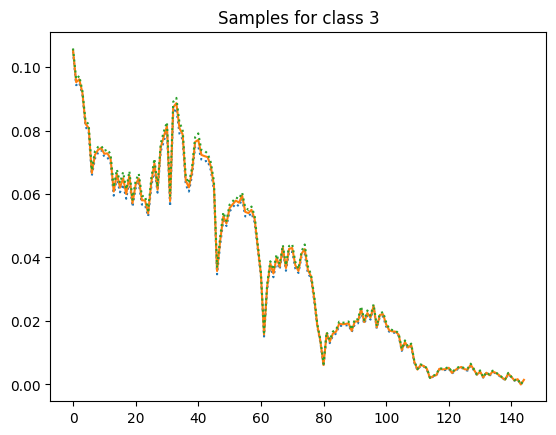

 90%|█████████████████████████████████████████████████████████████████▋       | 89999/100000 [1:49:23<12:15, 13.61it/s]

Iter-90000; D_loss: -0.002774639753624797; G_loss: 0.2866020202636719; C_loss: 0.07625997066497803


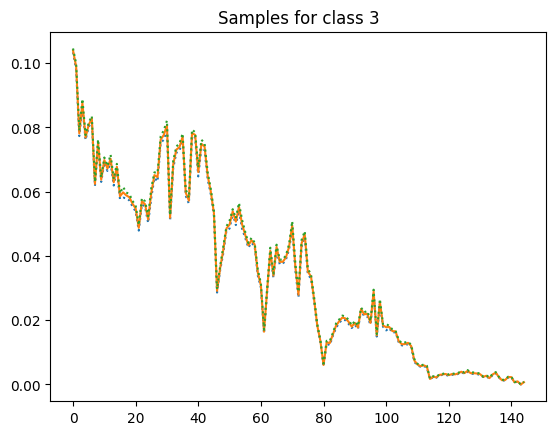

 91%|██████████████████████████████████████████████████████████████████▍      | 90999/100000 [1:50:37<12:09, 12.33it/s]

Iter-91000; D_loss: 6.016436964273453e-05; G_loss: -0.011097797192633152; C_loss: 0.03748539090156555


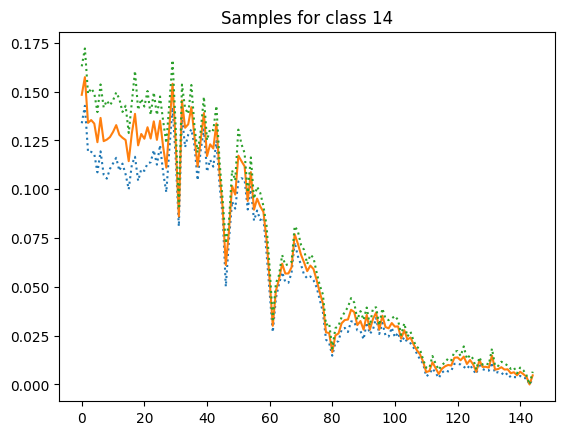

 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [1:51:51<08:50, 15.09it/s]

Iter-92000; D_loss: -0.0001828219392336905; G_loss: -0.11003600060939789; C_loss: 0.025569800287485123


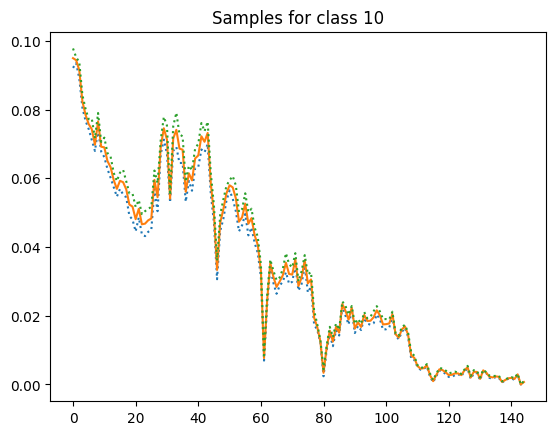

 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [1:53:02<08:15, 14.14it/s]

Iter-93000; D_loss: 0.0047692060470581055; G_loss: 0.1897134929895401; C_loss: 0.016477122902870178


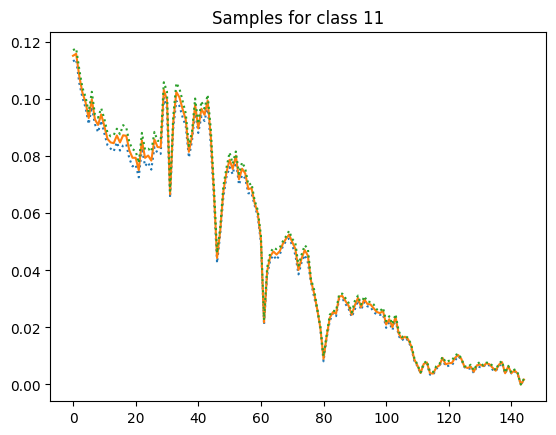

 94%|████████████████████████████████████████████████████████████████████▌    | 93999/100000 [1:54:17<08:26, 11.84it/s]

Iter-94000; D_loss: -0.00020894897170364857; G_loss: 0.06072169542312622; C_loss: 0.021495066583156586


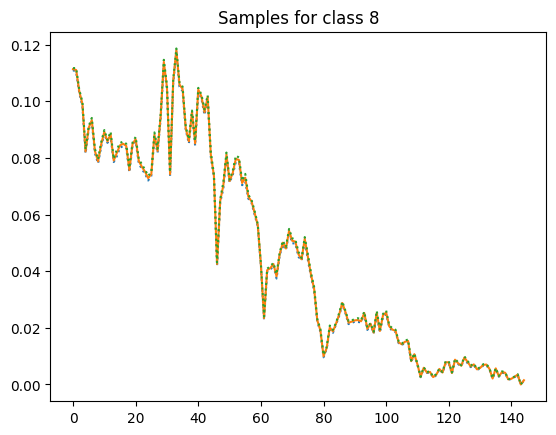

 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [1:55:33<06:26, 12.93it/s]

Iter-95000; D_loss: 0.009247617796063423; G_loss: 0.5564013123512268; C_loss: 0.029018402099609375


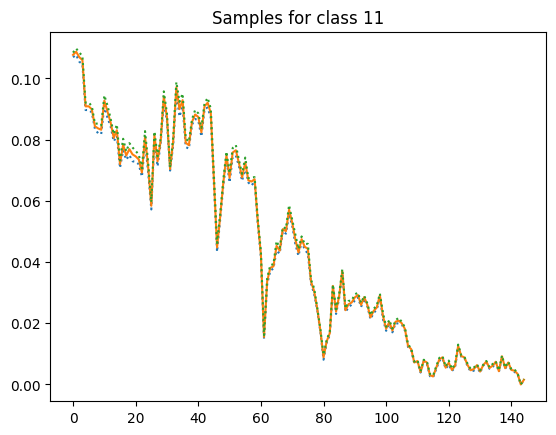

 96%|██████████████████████████████████████████████████████████████████████   | 95999/100000 [1:56:44<04:58, 13.39it/s]

Iter-96000; D_loss: -0.0062936171889305115; G_loss: 1.2027373313903809; C_loss: 0.34045201539993286


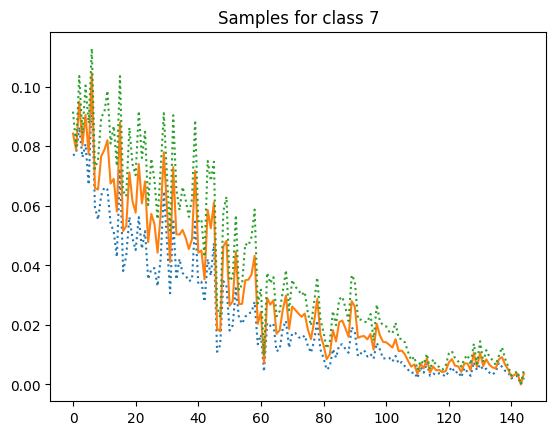

 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [1:57:58<03:56, 12.67it/s]

Iter-97000; D_loss: 0.003822989296168089; G_loss: 1.7120380401611328; C_loss: 0.021335221827030182


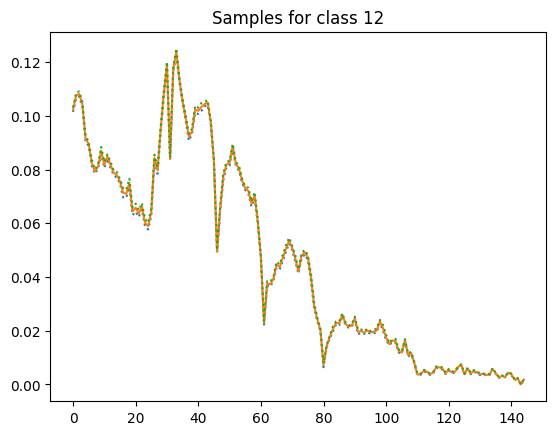

 98%|███████████████████████████████████████████████████████████████████████▌ | 98000/100000 [1:59:11<02:16, 14.67it/s]

Iter-98000; D_loss: 0.0006775939837098122; G_loss: 1.5969029664993286; C_loss: 0.02140112966299057


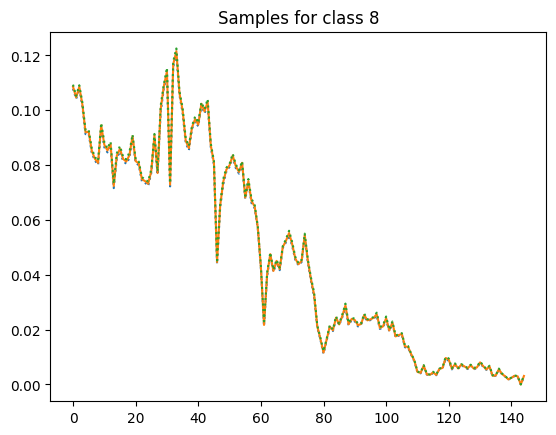

 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [2:00:23<01:04, 15.51it/s]

Iter-99000; D_loss: 0.0036175386048853397; G_loss: 1.2816864252090454; C_loss: 0.015219823457300663


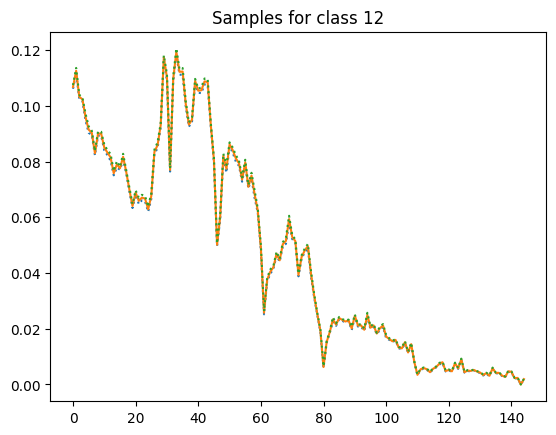

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [2:01:36<00:00, 13.71it/s]


In [9]:
import torch.optim as optim
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()


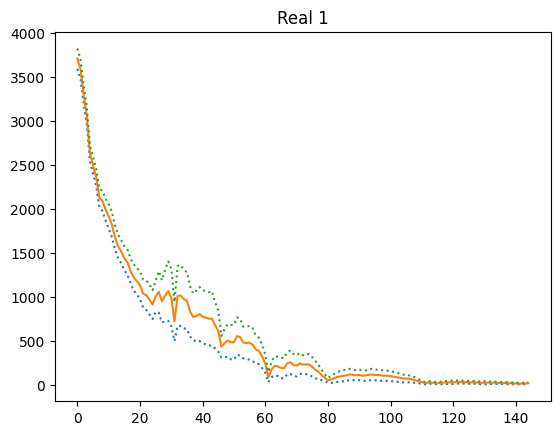

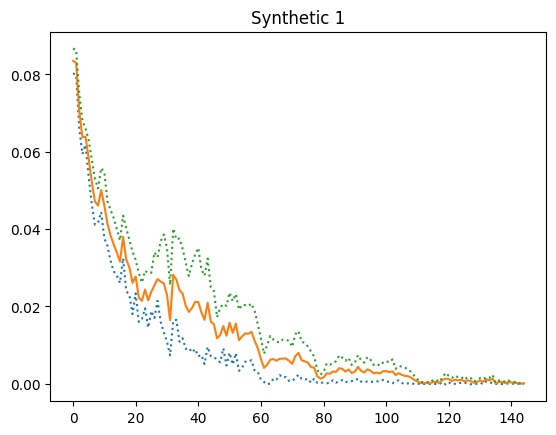

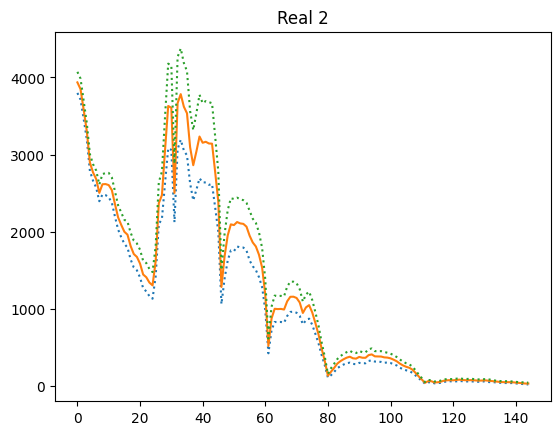

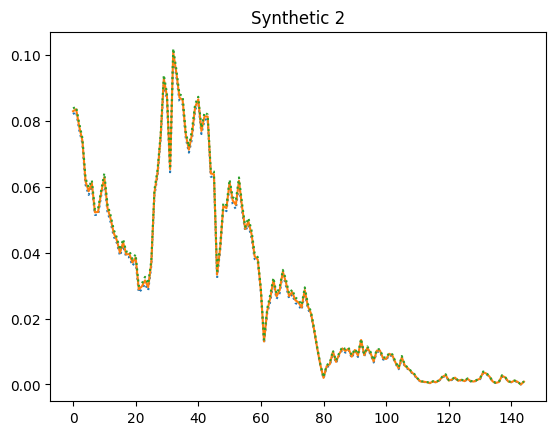

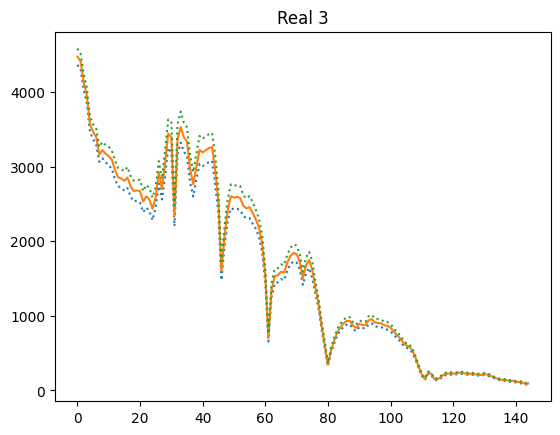

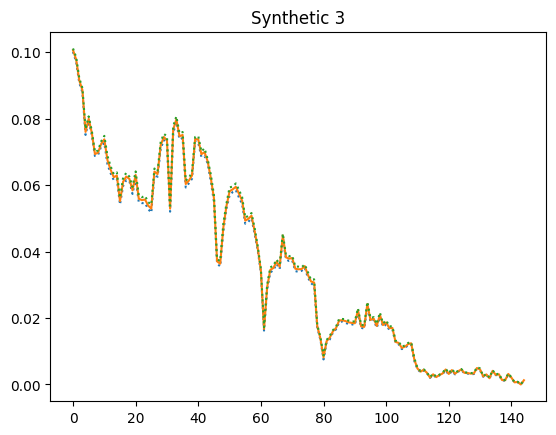

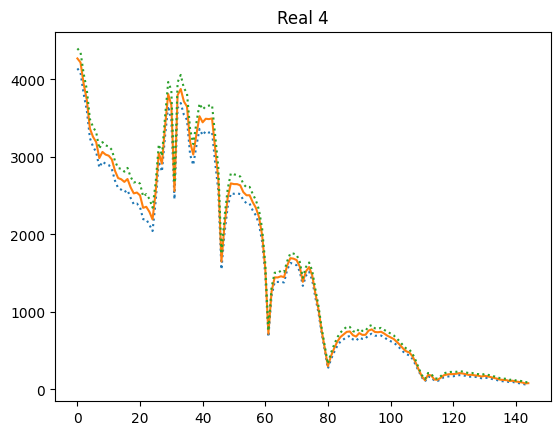

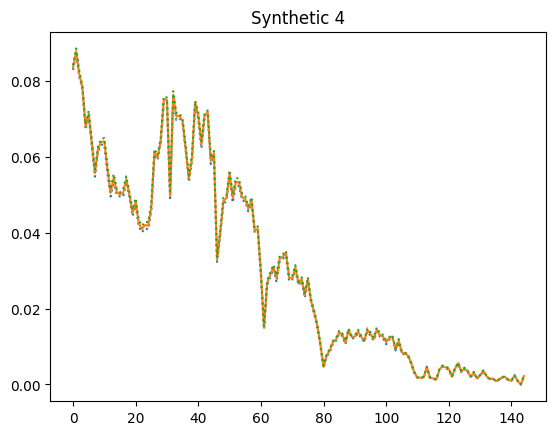

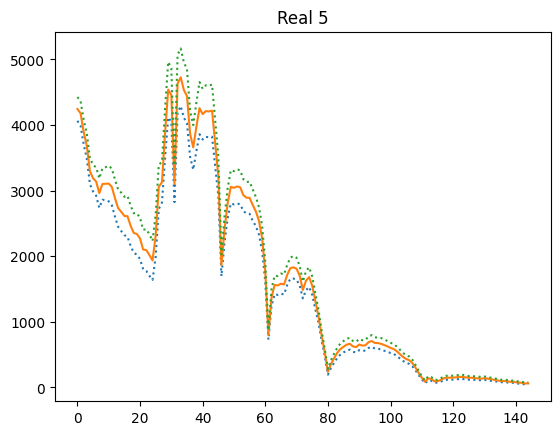

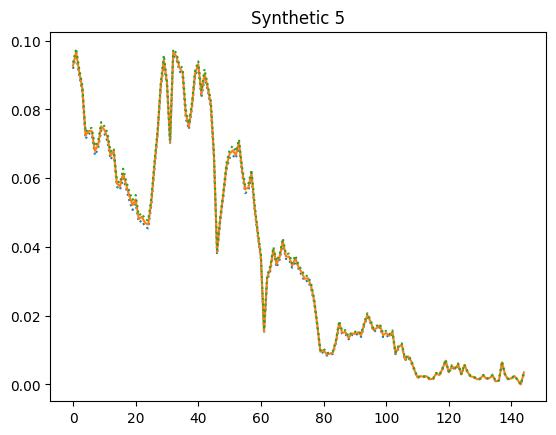

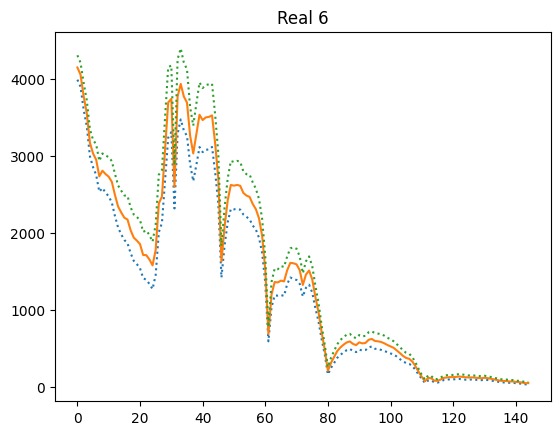

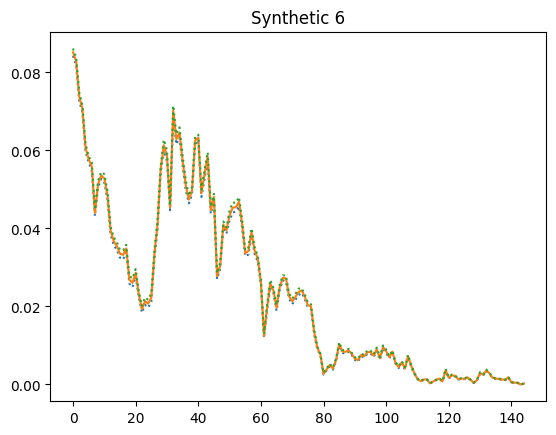

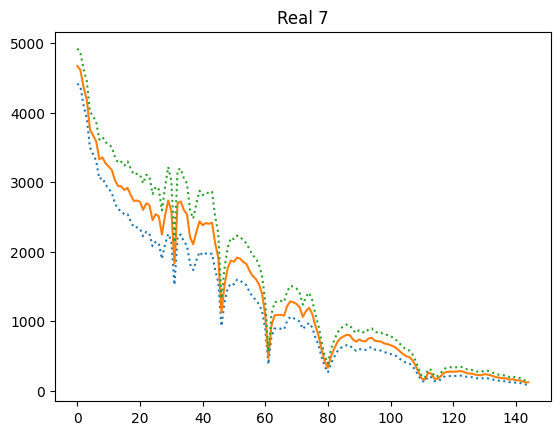

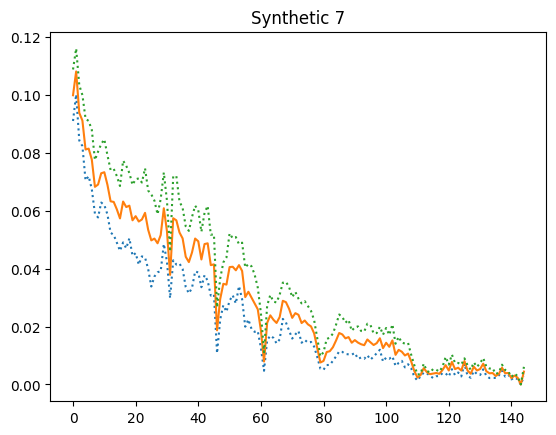

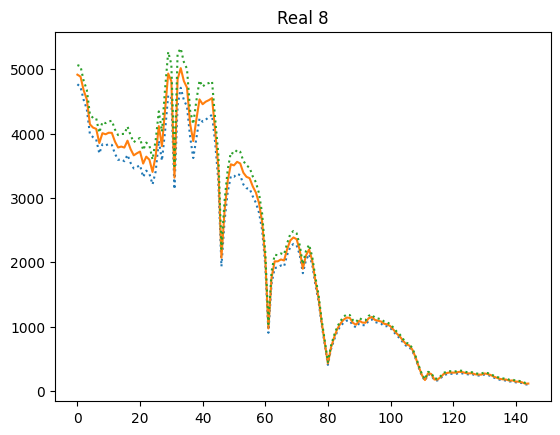

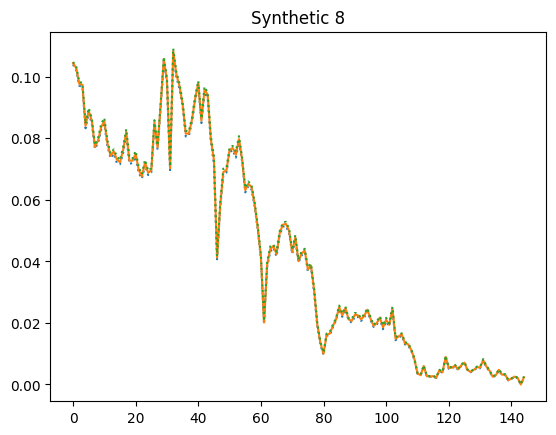

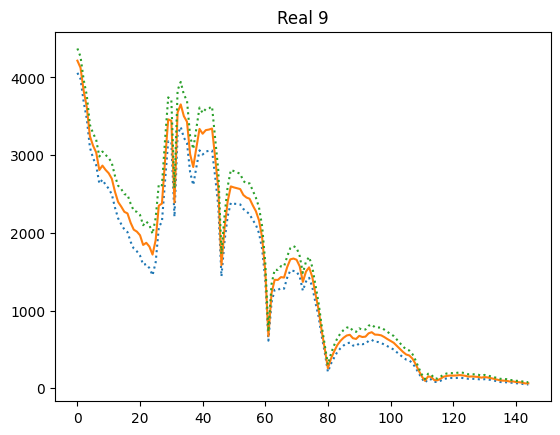

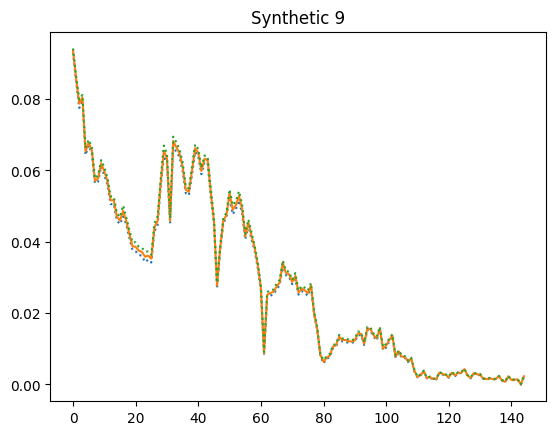

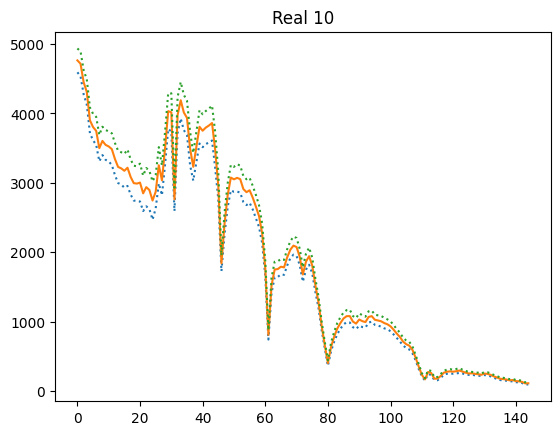

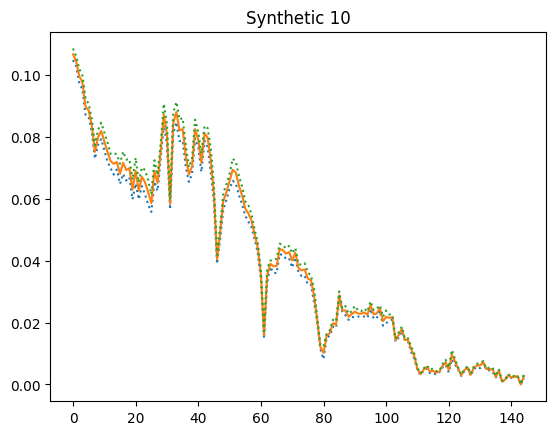

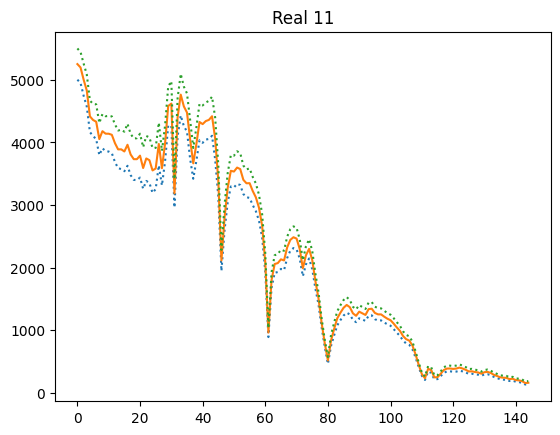

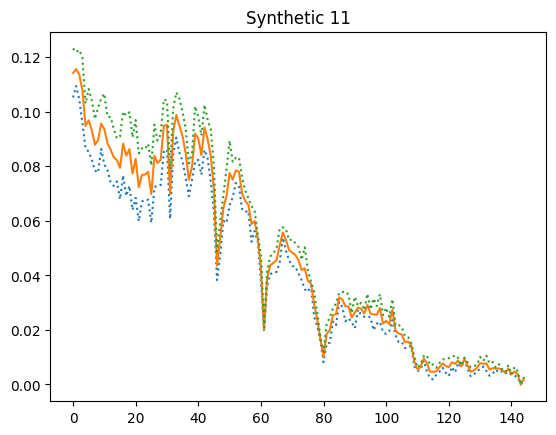

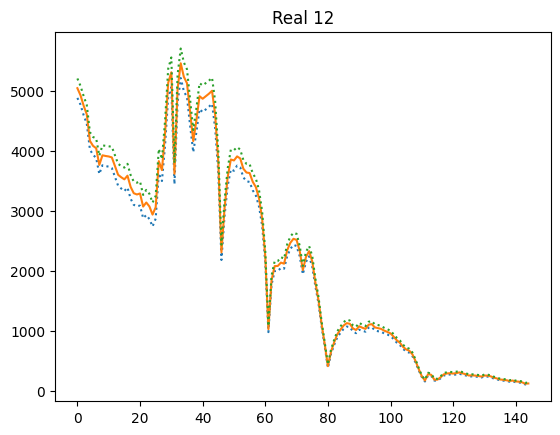

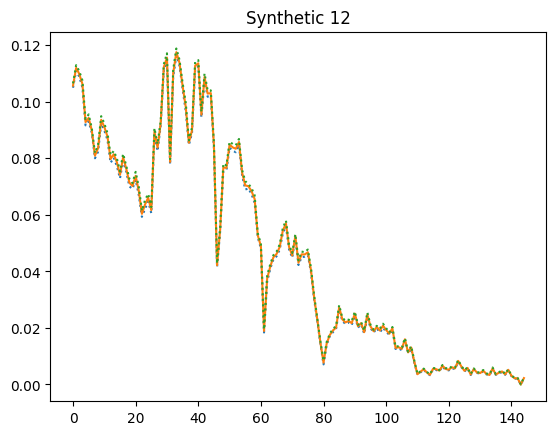

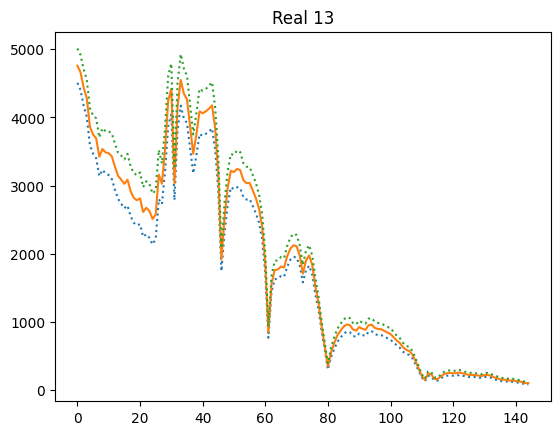

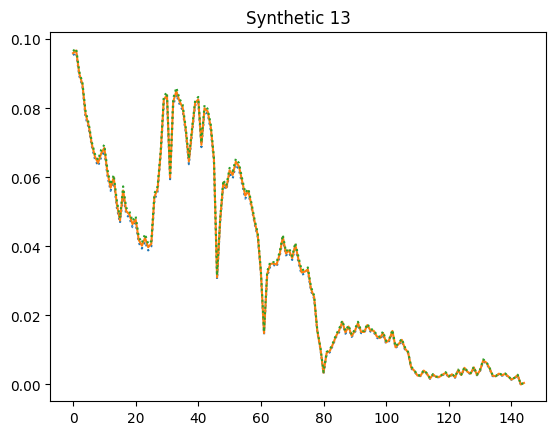

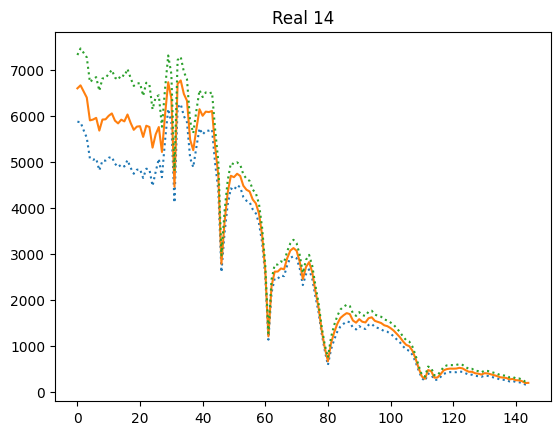

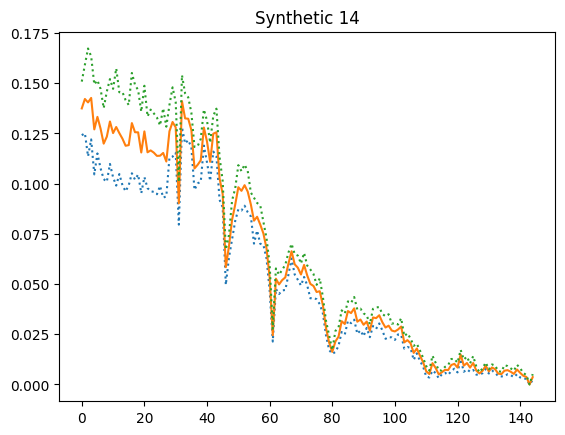

In [10]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [15]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [16]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [18]:
# gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
# for y in np.unique(y_train):
#     gmms[y].fit(X_train[y_train == y])
    
from sklearn.mixture import GaussianMixture
import numpy as np

# Initialize GMMs
gmms = [None] * c_dim

# Fit GMMs to each class with enough samples
for y in np.unique(y_train):
    # Get the samples for class y
    samples = X_train[y_train == y]
    # Check if there are at least two samples for this class
    if samples.shape[0] >= 2:
        # Set the number of components to be the min between the desired number and the number of samples
        n_components = min(20, samples.shape[0])
        gmms[y] = GaussianMixture(n_components=n_components)
        gmms[y].fit(samples)
    else:
        print(f"Not enough samples for class {y} to fit a GMM.")

In [19]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

In [20]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 86.72 accuracy.


In [21]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99       256
           2       0.96      0.97      0.96        94
           3       0.92      0.90      0.91       239
           4       0.83      0.91      0.87       204
           5       0.75      0.85      0.79       259
           6       0.71      0.48      0.57       261
           7       0.98      0.97      0.98       239
           8       0.94      0.97      0.95       194
           9       0.79      0.79      0.79       300
          10       0.76      0.92      0.83       230
          11       0.94      0.91      0.92       290
          12       0.99      0.78      0.87       174
          13       0.79      0.90      0.84       256
          14       1.00      0.98      0.99        84

    accuracy                           0.87      3080
   macro avg       0.88      0.88      0.88      3080
weighted avg       0.87      0.87      0.86      3080



In [24]:
# def gan_create_fake_dataset(labels):
#     with torch.no_grad():
#         spectras = []
#         for l in np.array_split(labels, len(labels) // mb_size):
#             z = torch.randn(len(l), z_dim).cuda()
#             y = np.zeros((len(l), data_loader.dataset.n_classes))
#             for i, label in enumerate(l):
#                 y[i] = np.eye(data_loader.dataset.n_classes)[label]
#             y = torch.from_numpy(y).float()
#             eps = torch.randn(y.size())/10
#             #y += eps
#             y = y.cuda()
#             G_sample = G(z, y)
#             spectras += list(G_sample.cpu().data.numpy())
#         return np.array(spectras), np.array(labels)


def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        # Ensure at least 1 section by using max function
        num_sections = max(1, len(labels) // mb_size)
        for l in np.array_split(labels, num_sections):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size()) / 10
            # Uncomment the next line if you want to add noise to y
            # y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)


In [25]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

In [26]:
clf.score(fake_X_test, fake_y_test)

0.8353896103896103

In [27]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       0.83      0.75      0.79       256
           2       1.00      1.00      1.00        94
           3       1.00      1.00      1.00       239
           4       1.00      1.00      1.00       204
           5       1.00      1.00      1.00       259
           6       1.00      1.00      1.00       261
           7       0.76      0.84      0.80       239
           8       0.99      1.00      1.00       194
           9       0.54      1.00      0.70       300
          10       1.00      0.94      0.97       230
          11       0.87      0.99      0.93       290
          12       1.00      0.41      0.59       174
          13       0.01      0.00      0.01       256
          14       0.95      0.63      0.76        84

    accuracy                           0.84      3080
   macro avg       0.85      0.83      0.82      3080
weighted avg       0.83      0.84      0.82      3080



In [28]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [29]:
clf_fake.score(fake_X_test, fake_y_test)

1.0

In [30]:
clf_fake.score(X_test, y_test)

0.575

In [31]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [32]:
clf_augmented.score(X_test, y_test)

0.8737012987012988

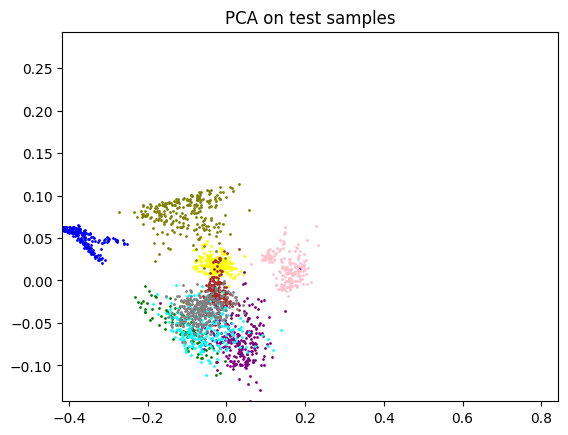

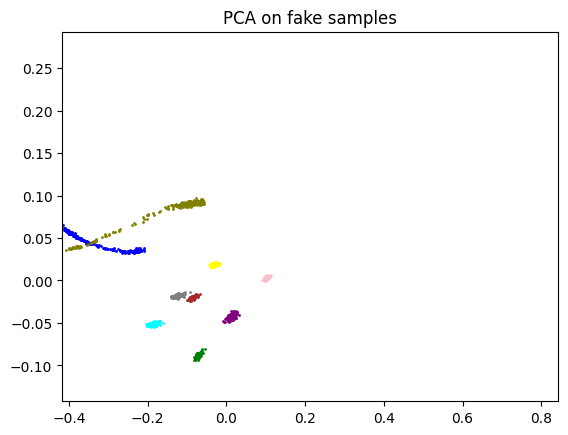

In [33]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

In [34]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

 67%|███████████████████████████████████████████████████▎                         | 9996/15000 [02:51<01:24, 58.93it/s]

Loss at 10000 = 0.0005225313943810761


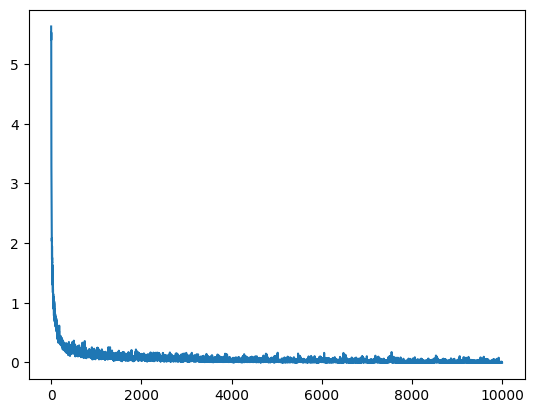

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:22<00:00, 57.18it/s]


In [35]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=15000)

In [36]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [37]:
test(C_real, X_test, y_test)

(3080, 145)
(3080,)
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       256
           2     0.9787    0.9787    0.9787        94
           3     1.0000    0.9791    0.9894       239
           4     0.9159    0.9608    0.9378       204
           5     0.7736    0.8842    0.8252       259
           6     0.7729    0.6782    0.7224       261
           7     0.9873    0.9791    0.9832       239
           8     0.9151    1.0000    0.9557       194
           9     0.9173    0.8500    0.8824       300
          10     0.7941    0.9391    0.8606       230
          11     1.0000    0.8207    0.9015       290
          12     0.9835    0.6839    0.8068       174
          13     0.7994    0.9805    0.8807       256
          14     0.9882    1.0000    0.9941        84

    accuracy                         0.9010      3080
   macro avg     0.9161    0.9096    0.9085      3080
weighted avg     0.9078    0.9010    0.9000      3080



array([14, 14, 14, ...,  6,  6,  6], dtype=int64)

 67%|███████████████████████████████████████████████████▎                         | 9997/15000 [03:47<01:49, 45.51it/s]

Loss at 10000 = 0.001847985782660544


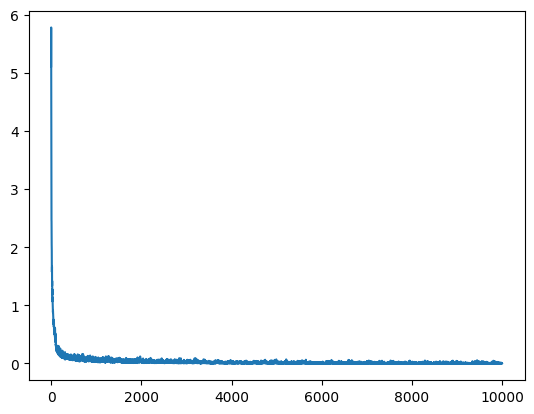

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [05:43<00:00, 43.70it/s]


In [38]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=15000)

In [39]:
test(C_fake, X_test, y_test)

(3080, 145)
(3080,)
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       256
           2     0.9490    0.9894    0.9688        94
           3     0.9915    0.9707    0.9810       239
           4     0.9132    0.9804    0.9456       204
           5     0.7774    0.8764    0.8240       259
           6     0.8000    0.5824    0.6741       261
           7     0.9871    0.9623    0.9746       239
           8     0.9104    0.9948    0.9507       194
           9     0.8804    0.8833    0.8819       300
          10     0.8052    0.9348    0.8652       230
          11     0.9766    0.8621    0.9158       290
          12     0.9291    0.7529    0.8317       174
          13     0.8401    0.9648    0.8982       256
          14     0.9540    0.9881    0.9708        84

    accuracy                         0.9006      3080
   macro avg     0.9081    0.9102    0.9059      3080
weighted avg     0.9028    0.9006    0.8982      3080



array([14, 14, 14, ...,  6,  6,  6], dtype=int64)